In [413]:
import numpy as np
import pandas as pd
import math
import os
import sys

import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# plot
import matplotlib.pyplot as plt

%matplotlib inline

RANDOM_STATE = 1

src_path = os.path.join("..")
if src_path not in sys.path:
    sys.path.append(src_path)

src_path = os.path.join("..", "src")
if src_path not in sys.path:
    sys.path.append(src_path)

src_path = os.path.join("..", "external", "HOSE_code_generator")
if src_path not in sys.path:
    sys.path.append(src_path)

from src import (
    common,
    atomic_features_2D,
    atomic_features_3D,
    hose_code,
)  # Some common methods I defined


pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 100)

import pickle
from IPython.display import display, Image

pd.options.mode.chained_assignment = None  # Suppress the SettingWithCopyWarning

# Plot parameters
tick_label_size = 10
axis_label_size = 12
legend_label_size = 10

def show_image(file_name):
    '''
    Show PFAS structure with atom idx in the notebook
    :param file_name: List of image file names (without extension)
    '''
    for i in range(len(file_name)):
        print(f'------------------------------------{file_name[i]}------------------------------------')
        figure_path = os.path.join("..", "dataset", "pictures", f"{file_name[i]}.png")
        display(Image(figure_path, width=400*0.7, height = 250*0.7))

# 1.1 Influence of No. Neighboring Atoms or Spheres on Model Performance

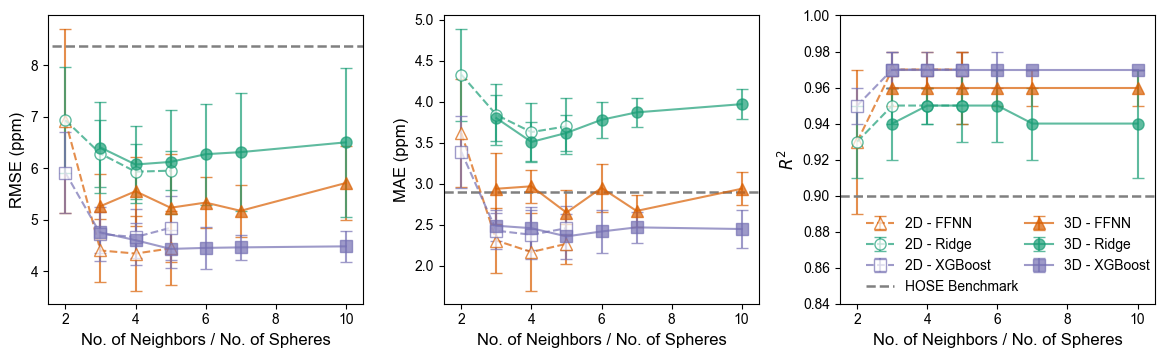

In [ ]:
validation_results_summary = pd.read_csv(
    os.path.join("..", "artifacts", "results", "Summary of validation results.csv"),
)
validation_results_summary['Feature Set'] = validation_results_summary['Feature Set'].replace({'2D feature set': '2D', '3D feature set': '3D'})

# Define the metrics you want to plot
metrics = ['RMSE', 'MAE', 'R2']

# Define mappings
model_styles = {
    'Ridge':   {'color': '#1b9e77', 'marker': 'o'},  # Teal - circle
    'XGBoost': {'color': '#7570b3', 'marker': 's'},  # Orange - square
    'FFNN':    {'color': '#d95f02', 'marker': '^'},  # Purple - triangle
}

feature_styles = {
    '2D': {'linestyle': '--', 'fill': 'none'},  # Hollow
    '3D': {'linestyle': '-',  'fill': 'full'}   # Solid
}

# Create a figure with 3 subplots
cm = 1 / 2.54  # centimeters in inches
fig, axes = plt.subplots(1, 3, figsize=(30*cm, 10*cm), sharex=True)

plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': axis_label_size,
    'axes.labelsize': axis_label_size,
    'legend.fontsize': legend_label_size,
    'xtick.labelsize': tick_label_size,
    'ytick.labelsize': tick_label_size
})
plt.rcParams['font.family'] = 'Arial'

# Loop through each metric and plot it
for i, metric in enumerate(metrics):
    ax = axes[i]
    metric_df = validation_results_summary[validation_results_summary['Matrics'] == metric]

    for (feature_set, model), group in metric_df.groupby(['Feature Set', 'Model']):
        m_style = model_styles.get(model, {'color': 'gray', 'marker': 'o'})
        f_style = feature_styles.get(feature_set, {'linestyle': '-', 'fill': 'full'})

        ax.errorbar(
            group['No. Units'],
            group['Value'],
            yerr=group['std'],
            label=f'{feature_set} - {model}',
            color=m_style['color'],
            marker=m_style['marker'],
            linestyle=f_style['linestyle'],
            markerfacecolor='white' if f_style['fill'] == 'none' else m_style['color'],
            markeredgecolor=m_style['color'],
            markersize=8,
            linewidth=1.5,
            capsize=4,
            alpha=0.7,
        )

    # ax.set_title(metric.upper())
    ax.set_xlabel("No. of Neighbors / No. of Spheres")
    ax.set_ylabel(metric.upper())
    ax.grid(False)
axes[2].set_ylim([0.84, 1.0])
axes[2].set_yticks([0.84, 0.86, 0.88, 0.90, 0.92, 0.94, 0.96, 0.98, 1.00])

ref_line0 = axes[0].plot([0, 11], [8.37, 8.37], color = 'grey', linewidth = 1.8, linestyle='--')
axes[0].set_xlim(1.5, 10.5)
axes[0].set_ylabel('RMSE (ppm)')

axes[1].plot([0, 11], [2.9, 2.9], color = 'grey', linewidth = 1.8, linestyle='--', label = 'HOSE code')
axes[1].set_xlim(1.5, 10.5)
axes[1].set_ylabel('MAE (ppm)')

axes[2].plot([0, 11], [0.90, 0.90], color = 'grey', linewidth = 1.8, linestyle='--',  label = 'HOSE code')
axes[2].set_xlim(1.5, 10.5)
axes[2].set_ylabel(r'$R^2$')

# Get all legend handles and labels
handles, labels = axes[0].get_legend_handles_labels()

# Separate first 3 and last 3 handles (3 models)
first_three_handles = handles[:3]
first_three_labels = labels[:3]
last_three_handles = handles[-3:]
last_three_labels = labels[-3:]

# Insert HOSE code line between them
handles = first_three_handles + [ref_line0[0]] + last_three_handles
labels = first_three_labels + ['HOSE Benchmark'] + last_three_labels

unique = dict(zip(labels, handles))
fig.legend(
    unique.values(),
    unique.keys(),
    bbox_to_anchor=(0.86, 0.41),
    loc='upper center',
    ncol=2,
    columnspacing=0.5,  # Default is 2.0, decrease this for tighter columns
    frameon=False,
    fontsize=legend_label_size 
)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


The plot shows the performance of each model with different feature sets across three metrics: RMSE, MAE, and R2.
The error bars represent the standard deviation of the metrics across different runs with 5 ramdom seeds.

From the plot, we can see that:
- The grey dashed line is the average performance of the HOSE code model, which serves as a baseline for comparison.
- The HOSE code model has an RMSE of 8.37 ± 1.89, MAE of 2.90 ± 0.51, and R2 of 0.90 ± 0.04.
- The large error bars of the HOSE code model indicate that it is not stable across different F atom configurations, which is expected since it is a rule-based model.

- The Ridge model performs the worst across all metrics, its MAE is even higher than the HOSE code model, indicating that it is not suitable for this task.

- The 2D feature set performs similar to the 3D feature set. Except for FFNN model, where the 2D feature set performs better than the 3D feature set. 
  This is contrary to the expectation that 3D feature set should perform better than 2D feature set.

- The best performing three models are 3D XGBoost with 5 neighboring atoms, 2D XGBoost with 5 neighboring spheres of atoms, and 2D FFNN with 5 neighboring spheres of atoms.
- There three models achieve similar performance across all metrics, with R2 around 0.97, RMSE around 4.4 ppm, and MAE around 2.4 ppm. 
- The low standard deviation of these models indicates that they are stable across different F atom configurations.

- Next, we will analyze the performance of these models in more detail. 
- We will analysis the relationship between model prediction error and the similarity of the F atom configuration to the training set.

In [ ]:
validation_results_summary[
    (validation_results_summary['Feature Set'] == '2D') & 
    (validation_results_summary['Model'] == 'XGBoost') &
    (validation_results_summary['No. Units'] == 5) 
]

,Feature Set,No. Units,Model,Matrics,Value,std
27,2D,5,XGBoost,RMSE,4.84,0.62
31,2D,5,XGBoost,MAE,2.46,0.27
35,2D,5,XGBoost,R2,0.97,0.01


In [590]:
validation_results_summary[
    (validation_results_summary['Feature Set'] == '3D') & 
    (validation_results_summary['Model'] == 'XGBoost') &
    (validation_results_summary['No. Units'] == 5) 
]

,Feature Set,No. Units,Model,Matrics,Value,std
74,3D,5,XGBoost,RMSE,4.43,0.37
80,3D,5,XGBoost,MAE,2.36,0.27
86,3D,5,XGBoost,R2,0.97,0.00


In [589]:
validation_results_summary[
    (validation_results_summary['Feature Set'] == '2D') & 
    (validation_results_summary['Model'] == 'FFNN') &
    (validation_results_summary['No. Units'] == 5) 
]

,Feature Set,No. Units,Model,Matrics,Value,std
15,2D,5,FFNN,RMSE,4.44,0.72
19,2D,5,FFNN,MAE,2.27,0.24
23,2D,5,FFNN,R2,0.97,0.01


# 1.2 Compare Top 3 Model Performance Among Various Similarity Levels

In [334]:
HOSE_file_path = os.path.join(
    "..", "artifacts", "results", "HOSE Results On Validation Dataset with 5 Random Seeds.csv"
)
hose_vali = pd.read_csv(HOSE_file_path)

# Top three performing models:
xgboost_train_3d_n5= pd.read_csv(os.path.join("..", "artifacts", "results", "XGBoost 3D_n5_Results On Training Dataset with 5 Random Seeds.csv"))
xgboost_vali_3d_n5= pd.read_csv(os.path.join("..", "artifacts", "results", "XGBoost 3D_n5_Results On Validation Dataset with 5 Random Seeds.csv.csv"))

xgboost_train_2d_s5= pd.read_csv(os.path.join("..", "artifacts", "results", "XGBoost 2D_s5_Results On Training Dataset with 5 Random Seeds.csv"))
xgboost_vali_2d_s5= pd.read_csv(os.path.join("..", "artifacts", "results", "XGBoost 2D_s5_Results On Validation Dataset with 5 Random Seeds.csv.csv"))

FFNN_train_2d_s5 = pd.read_csv(os.path.join("..", "artifacts", "results", "FFNN 2D_s5_Results On Training Dataset with 5 Random Seeds.csv"))
FFNN_vali_2d_s5 = pd.read_csv(os.path.join("..", "artifacts", "results", "FFNN 2D_s5_Results On Validation Dataset with 5 Random Seeds.csv.csv"))

# HOSE Code
HOSE_code_train_tables = pd.read_csv(os.path.join("..", "artifacts", "results", "HOSE_code_train_tables_with_5_random_seeds.csv"), index_col=0)

HOSE_code_vali_tables = pd.read_csv(os.path.join("..", "artifacts", "results", "HOSE_code_vali_tables_with_5_random_seeds.csv"), index_col=0)
HOSE_code_vali_tables = HOSE_code_vali_tables.dropna(subset = 'NMR_Peaks')

,Unnamed: 0,actual,prediction,diff,similarity_levels
0,4_COOH_29,-120.1,-119.621538,0.478462,6
1,5_COOH_29,-120.1,-119.621538,0.478462,6
2,7_COOH_29,-122.8,-122.301818,0.498182,6
3,8_COOH_29,-122.8,-122.301818,0.498182,6
4,10_COOH_29,-122.8,-122.325000,0.475000,6
...,...,...,...,...,...
3164,10_From_Review_296,-79.0,-77.316667,1.683333,3
3165,11_From_Review_296,-79.0,-77.316667,1.683333,3
3166,7_From_Review_298,-75.0,-75.500000,0.500000,4
3167,8_From_Review_298,-75.0,-75.500000,0.500000,4


In [340]:
combined_vali = hose_vali.copy()
combined_vali = combined_vali.rename(columns={"diff": "HOSE Code"}).drop(columns=["prediction"])
combined_vali['XGBoost 3D_n5'] = xgboost_vali_3d_n5['diff']
combined_vali['XGBoost 2D_s5'] = xgboost_vali_2d_s5['diff']
combined_vali['FFNN 2D_s5'] = FFNN_vali_2d_s5['diff']


combined_train = xgboost_train_3d_n5.copy()
combined_train = combined_train.rename(columns={"diff": "XGBoost 3D_n5"}).drop(columns=["prediction"])
combined_train['XGBoost 2D_s5'] = xgboost_train_2d_s5['diff']
combined_train['FFNN 2D_s5'] = FFNN_train_2d_s5['diff']

# The validation dataset and train dataset were generated by splitting the original dataset using 5 random seeds, and then concat the results.
# The split points are as follows:
vali_split_points = [663, 1284, 1894, 2446, 3169]
train_split_points = [2217, 4476, 6746, 9074, 11231]

In [341]:
print(f'Shape of combined_vali: {combined_vali.shape}')
display(combined_vali.head())

print(f'Shape of combined_train: {combined_train.shape}')
display(combined_train.head())

Shape of combined_vali: (3169, 7)


,Unnamed: 0,actual,HOSE Code,similarity_levels,XGBoost 3D_n5,XGBoost 2D_s5,FFNN 2D_s5
0,4_COOH_29,-120.1,0.478462,6,0.378938,0.525682,0.203345
1,5_COOH_29,-120.1,0.478462,6,0.378938,0.525682,0.203345
2,7_COOH_29,-122.8,0.498182,6,0.140286,0.399167,0.039386
3,8_COOH_29,-122.8,0.498182,6,0.179066,0.399167,0.039386
4,10_COOH_29,-122.8,0.475000,6,0.152531,0.295132,0.267886


Shape of combined_train: (11231, 5)


,Unnamed: 0,actual,XGBoost 3D_n5,XGBoost 2D_s5,FFNN 2D_s5
0,0_From_Review_24,-208.00,5.643631,5.457031,0.499374
1,6_From_Review_97,-133.00,0.535736,8.241989,3.087006
2,7_From_Review_93,-173.00,3.043503,2.472244,0.713089
3,0_ethers_1,-87.11,1.457947,1.230530,1.651946
4,2_ethers_1,-87.11,3.630546,1.230530,1.651946


In [342]:
combined_vali_with_predicted_shifts = hose_vali.copy()
combined_vali_with_predicted_shifts = combined_vali_with_predicted_shifts.rename(columns={"prediction": "HOSE Code"}).drop(columns=["diff"])
combined_vali_with_predicted_shifts['XGBoost 3D_n5'] = xgboost_vali_3d_n5['prediction']
combined_vali_with_predicted_shifts['XGBoost 2D_s5'] = xgboost_vali_2d_s5['prediction']
combined_vali_with_predicted_shifts['FFNN 2D_s5'] = FFNN_vali_2d_s5['prediction']
combined_vali_with_predicted_shifts.head(3)

,Unnamed: 0,actual,HOSE Code,similarity_levels,XGBoost 3D_n5,XGBoost 2D_s5,FFNN 2D_s5
0,4_COOH_29,-120.1,-119.621538,6,-119.72106,-119.57432,-120.303345
1,5_COOH_29,-120.1,-119.621538,6,-119.72106,-119.57432,-120.303345
2,7_COOH_29,-122.8,-122.301818,6,-122.65971,-122.40083,-122.839386


HOSE Code                                   XGBoost 3D_n5  \
                        mean        std        min         max          mean   
similarity_levels                                                              
1                  66.942709  31.606053  34.863245  103.569594     14.014288   
2                  12.297999  11.600927   0.049167   65.236429      6.425860   
3                   2.750561   2.779944   0.018571   18.000000      3.322607   
4                   1.213984   1.788723   0.000000   14.813000      2.956119   
5                   0.596580   0.603328   0.000000    6.000000      1.015970   

                                                  XGBoost 2D_s5            \
                         std       min        max          mean       std   
similarity_levels                                                           
1                  13.050458  0.412956  35.521988     11.132142  6.771699   
2                   6.308333  0.025963  39.920509      6.785103  7.530148   
3                   3.222740  0.005585  21.504272      3.607364  4.188386   
4                   4.151768  0.004898  24.901618      2.631359  3.455985   
5                   1.425427  0.000285  17.277766      1.037352  1.882271   

                                       FFNN 2D_s5                      \
                        min        max       mean       std       min   
similarity_levels                                                       
1                  2.192535  20.092712   7.472925  6.331276  0.715454   
2                  0.013382  48.630981   6.634811  7.101853  0.009265   
3                  0.019889  31.926751   3.233429  4.346416  0.005211   
4                  0.065845  27.011597   2.407905  2.512348  0.004158   
5                  0.000465  32.501053   0.854497  1.062029  0.001794   

                              
                         max  
similarity_levels             
1                  19.022179  
2                  41.628281  
3                  30.808014  
4                  15.413063  
5                  14.211400

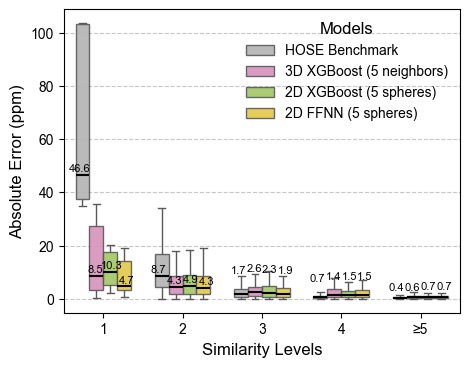

In [536]:
combined_vali_copy = combined_vali.copy()
combined_vali_copy['similarity_levels'] = combined_vali_copy['similarity_levels'].apply(lambda x:x if x < 5 else 5)
column_list = ["HOSE Code", "XGBoost 3D_n5", "XGBoost 2D_s5", "FFNN 2D_s5"]
grouped_df = combined_vali_copy.groupby("similarity_levels")[
    column_list
].agg(["mean", "std", "min", "max"])
display(grouped_df)

# Set the figure size
cm = 1 / 2.54  # centimeters in inches
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(13 * cm, 10 * cm)) 

# Melt the DataFrame to transform it into a long format suitable for Seaborn
df_melted = combined_vali_copy.melt(id_vars=['similarity_levels'], 
                          value_vars=column_list, 
                          var_name='Model', 
                          value_name='Error')
# display(df_melted)
df_melted = df_melted[df_melted['similarity_levels'] > 0]


custom_palette = ['#B3B3B3', '#E186BE', '#A6D753', '#FAD930']

# Create the boxplot for error distribution across similarity levels
ax = sns.boxplot(
    x='similarity_levels', 
    y='Error', 
    hue='Model',  # Different colors for different models
    data=df_melted, 
    width=0.7, 
    showcaps=True, 
    palette=custom_palette,  # Use a visually appealing color scheme
    medianprops={'color':'black', 'linewidth':1.5},
    showfliers=False, # Show outliers
)

for patch in ax.patches:
    patch.set_alpha(0.9)  # Set your desired alpha (0.0 to 1.0)
    
# Adjust legend
handles, labels = ax.get_legend_handles_labels()
custom_labels = [
    "HOSE Benchmark", 
    "3D XGBoost (5 neighbors)", 
    "2D XGBoost (5 spheres)",
    "2D FFNN (5 spheres)"
]
plt.legend(handles[:8], custom_labels, frameon=False, title = "Models", loc="upper right", fontsize = legend_label_size)
# plt.legend()
# Add title and labels
# plt.title("Absolute Error Distribution of Models Across Similarity Levels", fontsize=14, fontweight='bold')
plt.xlabel("Similarity Levels", fontsize=axis_label_size)
plt.ylabel("Absolute Error (ppm)", fontsize=axis_label_size)
if max(combined_vali_copy['similarity_levels']) == 6:
    plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=['1', '2', '3', '4', '5', '6'], fontsize=tick_label_size)
else:
    plt.xticks(ticks=[0, 1, 2, 3, 4], labels=['1', '2', '3', '4', '≥5'], fontsize=tick_label_size)
plt.yticks(fontsize=tick_label_size)

# Improve grid visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Compute median values grouped by similarity level and model, and note the median values above the boxes
median_values = (
    df_melted.groupby(['similarity_levels', 'Model'])['Error']
    .median()
    .reset_index()
)

# Get order of hue levels (models) and similarity levels
hue_order = df_melted['Model'].unique()
x_order = sorted(df_melted['similarity_levels'].unique())

# Create a mapping from (similarity_level, model) to median value
median_dict = {
    (row['similarity_levels'], row['Model']): row['Error']
    for _, row in median_values.iterrows()
}

# Loop to plot text manually
for i, sim_level in enumerate(x_order):
    if sim_level == 3:
        for j, model in enumerate(hue_order):
            median = median_dict.get((sim_level, model), None)
            if median is not None:
                # Compute x-position for this box: i is the similarity level index, j is the model index
                group_width = 0.8  # Seaborn default width for grouped boxplots
                n_models = len(hue_order)
                spacing = group_width / n_models
                x = i - group_width / 2 + spacing * j + spacing / 2

                ax.text(x, median + 7, f'{median:.1f}', ha='center', va='bottom', fontsize=8, color='black')
    
    elif sim_level == 4:
        for j, model in enumerate(hue_order):
            median = median_dict.get((sim_level, model), None)
            if median is not None:
                # Compute x-position for this box: i is the similarity level index, j is the model index
                group_width = 0.8  # Seaborn default width for grouped boxplots
                n_models = len(hue_order)
                spacing = group_width / n_models
                x = i - group_width / 2 + spacing * j + spacing / 2

                ax.text(x, median + 5, f'{median:.1f}', ha='center', va='bottom', fontsize=8, color='black')

    elif sim_level == 5:
        for j, model in enumerate(hue_order):
            median = median_dict.get((sim_level, model), None)
            if median is not None:
                # Compute x-position for this box: i is the similarity level index, j is the model index
                group_width = 0.8  # Seaborn default width for grouped boxplots
                n_models = len(hue_order)
                spacing = group_width / n_models
                x = i - group_width / 2 + spacing * j + spacing / 2

                ax.text(x, median + 2, f'{median:.1f}', ha='center', va='bottom', fontsize=8, color='black')

    else:
        for j, model in enumerate(hue_order):
            median = median_dict.get((sim_level, model), None)
            if median is not None:
                # Compute x-position for this box: i is the similarity level index, j is the model index
                group_width = 0.8  # Seaborn default width for grouped boxplots
                n_models = len(hue_order)
                spacing = group_width / n_models
                x = i - group_width / 2 + spacing * j + spacing / 2

                ax.text(x, median + 0.5, f'{median:.1f}', ha='center', va='bottom', fontsize=8, color='black')
# Show the plot
plt.show()


- The boxplot shows the absolute error distribution of the top 3 best performaing models across similarity levels.
- F atom with similarity level >= 4 means that the F atom has at least 4 neighboring spheres of atoms that are similar to one or more of the F atoms in the training dataset.
- The HOSE code model's prediction error increased significantly with the decreasing similarity level. 
- This is expected since the HOSE code model is a rule-based model that relies on the similarity of the F atom to the training dataset.

- The top three performing models's prediction error also increased with the decreasing similarity level, but not as significantly as the HOSE code model.
- At similarity level >= 3, all four models show similar performance, with median absolute error around 0.6 ppm (similarity levels >= 4) and 2.0 ppm (similarity levels = 3).
- At similarity level 2, the three examined models show much lower absolute error (median ~ 4.5 ppm) than the HOSE code model (median 8.7 ppm), indicating that they can well predict novel F atoms that are not similar to the training dataset.
- This is more pronounced for F atoms with similarity level 1, where the HOSE code model has a high median absolute error of 46.6 ppm, 
while the three examined models have much lower absolute error (median ~ 4.7 ppm for FFNN, ~ 10.3 ppm for XGBoost with 2D feature set, and ~ 8.5 ppm for XGBoost with 3D feature set).

- In summary, the 2D FFNN model was chosen as the besting performing model. 
 It performs well across all similarity levels, especially for F atoms with similarity level 1 and 2, where it has the lowest median absolute error compared to the other models.
This indicated the FFNN model is more generalizable and can better predict novel F atoms that are not similar to the training dataset.

In [304]:
print('----------------Performance of FFNN 2D_s5 on validation dataset----------------')
r2 = r2_score(FFNN_vali_2d_s5['actual'], FFNN_vali_2d_s5['prediction'])
mae = mean_absolute_error(FFNN_vali_2d_s5['actual'], FFNN_vali_2d_s5['prediction'])
rmse = math.sqrt(mean_squared_error(FFNN_vali_2d_s5['actual'], FFNN_vali_2d_s5['prediction']))
print(f'R2: {r2:.3f}, MAE: {mae:.3f}, RMSE: {rmse:.3f}')

----------------Performance of FFNN 2D_s5 on validation dataset----------------
R2: 0.974, MAE: 2.214, RMSE: 4.428


In [302]:
FFNN_vali_2d_s5

,Unnamed: 0,actual,prediction,diff
0,4_COOH_29,-120.1,-120.303345,0.203345
1,5_COOH_29,-120.1,-120.303345,0.203345
2,7_COOH_29,-122.8,-122.839386,0.039386
3,8_COOH_29,-122.8,-122.839386,0.039386
4,10_COOH_29,-122.8,-123.067890,0.267886
...,...,...,...,...
3164,10_From_Review_296,-79.0,-79.888360,0.888359
3165,11_From_Review_296,-79.0,-79.888360,0.888359
3166,7_From_Review_298,-75.0,-68.255720,6.744278
3167,8_From_Review_298,-75.0,-68.255720,6.744278


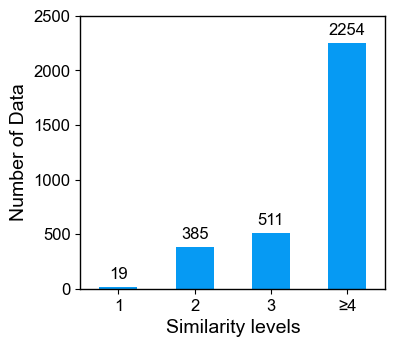

In [7]:
# Ratio of F atoms in each similarity level in the validation dataset
# Plot the distribution of data points across different similarity levels
# Sort the value counts by the index (the similarity levels)
results = combined_vali.copy()

sorted_counts = results["similarity_levels"].value_counts(normalize=False).sort_index()

cm = 1 / 2.54  # centimeters in inches
fig, ax = plt.subplots(figsize=(10 * cm, 9 * cm))  # 8 cm x 8 cm

# Plotting the sorted value counts
ax = sorted_counts.plot(kind="bar", color="#069AF3")

# Adding the percentage labels above each bar
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.0f}",  # Format the height as a percentage
        (
            p.get_x() + p.get_width() / 2.0,
            p.get_height(),
        ),  # Position for the annotation
        ha="center",  # Horizontal alignment: center
        va="center",  # Vertical alignment: center
        xytext=(0, 9),  # Offset the text by 9 points above the bar
        textcoords="offset points",  # Use offset points to position the text
    )

# Set border (edge) line width
ax.spines["top"].set_linewidth(1)  # Top border
ax.spines["right"].set_linewidth(1)  # Right border
ax.spines["bottom"].set_linewidth(1)  # Bottom border
ax.spines["left"].set_linewidth(1)  # Left border

# Set axis titles and tick label font sizes
ax.set_xlabel("Similarity levels", fontsize=14)  # Replace with your label
ax.set_ylabel("Number of Data", fontsize=14)  # Replace with your label
ax.tick_params(axis="x", labelsize=12)  # X-axis numbers font size
ax.tick_params(axis="y", labelsize=12)  # Y-axis numbers font size

ax.set_ylim([0, 2500])
ax.set_yticks([0, 500, 1000, 1500, 2000, 2500])  # Set x-axis labels to be more readable
# Set the x-axis labels in the correct order
ax.set_xticklabels(sorted_counts.index)
ax.tick_params(axis="x", rotation=0)
plt.xticks(ticks=[0, 1, 2, 3], labels=['1', '2', '3', '≥4'])
plt.show()

# 1.3 Error Distribution Analysis

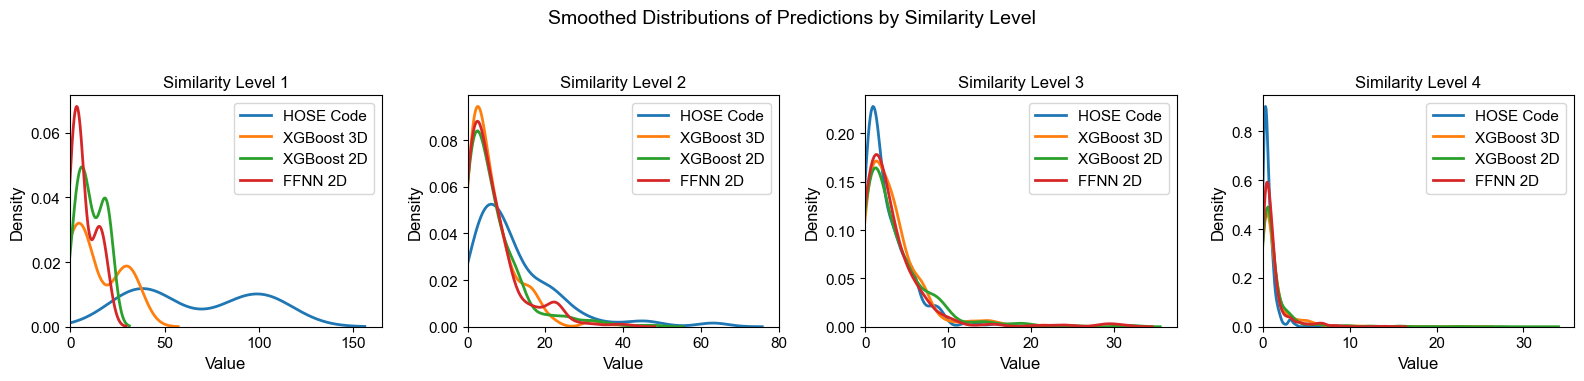

In [30]:
# Create sub-dataframes for each similarity level
temp_4 = combined_vali[combined_vali['similarity_levels'] == 4]
temp_3 = combined_vali[combined_vali['similarity_levels'] == 3]
temp_2 = combined_vali[combined_vali['similarity_levels'] == 2]
temp_1 = combined_vali[combined_vali['similarity_levels'] == 1]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, temp in enumerate([temp_1, temp_2, temp_3, temp_4]):
    ax = axes[i]
    sns.kdeplot(temp['HOSE Code'], label='HOSE Code', linewidth=2, ax=ax)
    sns.kdeplot(temp['XGBoost 3D_n5'], label='XGBoost 3D', linewidth=2, ax=ax)
    sns.kdeplot(temp['XGBoost 2D_s5'], label='XGBoost 2D', linewidth=2, ax=ax)
    sns.kdeplot(temp['FFNN 2D_s5'], label='FFNN 2D', linewidth=2, ax=ax)

    ax.set_title(f'Similarity Level {i+1}')
    ax.set_xlabel('Value')
    ax.set_xlim(left=0)

    # if i == 0:
    #     ax.set_ylabel('Density')
    # else:
    #     ax.set_ylabel('')
    ax.legend()

plt.suptitle('Smoothed Distributions of Predictions by Similarity Level', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



In [217]:
def plot_cumulative_stacked_bar(results_table, models = ["HOSE Code", "XGBoost 3D_n5", "XGBoost 2D_s5", "FFNN 2D_s5"], 
                                model_labels = ["HOSE", "Best 3D XGBoost", "Bset 2D XGBoost", "Best 2D FFNN"]):
    
    total_count = len(results_table)
    # thresholds = [1, 2, 3, 5, 10, 20]
    thresholds = [200, 20, 10, 5, 3, 2, 1]
    colors = ['grey', "#C04F16", "#F2AA84", "#FBE3D6", "#C1E5F5", "#83CBEB", '#4D9AF3']

    # Initialize cumulative proportions for each model
    cumulative_proportions = {model: [0] * len(thresholds) for model in models}

    # Calculate cumulative proportions for each model at each threshold
    for model in models:
        num_below_cumulative = [0] * len(thresholds)  # Initialize cumulative counts
        for value in results_table[model]:
            for i, threshold in enumerate(thresholds):
                if value < threshold:
                    num_below_cumulative[i] += 1
        # Convert counts to cumulative proportions
        cumulative_proportions[model] = [
            count / total_count for count in num_below_cumulative
        ]

    # Transpose cumulative proportions for plotting
    stacked_data = np.array([cumulative_proportions[model] for model in models])
    df = pd.DataFrame(stacked_data, columns=thresholds, index=model_labels)
    display(df)

    # Plotting
    cm = 1 / 2.54  # centimeters in inches
    plt.rcParams['font.family'] = 'Arial'
    _, ax = plt.subplots(figsize=(12 * cm, 9 * cm))  # Adjust size as needed
    left = np.zeros(len(models))  # Initialize bottom to zero for each model

    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Plot cumulative stacked bars
    for i, (threshold, color) in enumerate(zip(thresholds, colors)):
        #         ax.bar(model_labels, stacked_data[:, i], bottom=bottom, label=f'Threshold < {threshold}', color=color)
        ax.barh(
            model_labels,
            stacked_data[:, i],
            left=left,
            label=f"{threshold} ppm",
            color=color,
        )
        bottom = stacked_data[
            :, i
        ]  # Update bottom to cumulative total for each threshold

    # Labels and formatting
    ax.set_xlabel("Cumulative Proportion")
    # ax.set_ylabel("Cumulative Proportion")
    ax.set_xlim(0, 1)

    # custom_labels = ["<1 ppm", "1-2 ppm", "2-5 ppm", "5-10 ppm", "10-20 ppm", "≥20 ppm"]
    custom_labels = ["≥20 ppm", "10-20 ppm", "5-10 ppm", "2-5 ppm", "2-3", "1-2 ppm", "<1 ppm"]
    # plt.legend(handles[:8], custom_labels, frameon=False, title = "Models", loc="upper right")

    ax.legend(custom_labels, 
        title="Absolute Error\n  Thresholds", frameon=False, bbox_to_anchor=(1.01, 1), loc="upper left"
    )

    # # Make only 'Ensemble', 'HOSE', and '3D XGBoost' labels bold
    # ytick_labels = ax.get_yticklabels()
    # for i, label in enumerate(ytick_labels):
    #     if label.get_text() in ["Ensemble XGBoost", "3D XGBoost", "HOSE"]:
    #         label.set_fontweight('bold')
    #         label.set_size(12)
    # ax.set_yticklabels(ytick_labels)

    # plt.xticks(rotation=45)
    plt.show()

,200,20,10,5,3,2,1
HOSE,1.0,0.973178,0.938466,0.870937,0.807826,0.776586,0.601136
Best 3D XGBoost,1.0,0.990849,0.953929,0.868413,0.760492,0.686021,0.495424
Bset 2D XGBoost,1.0,0.987062,0.949195,0.863364,0.789839,0.706216,0.532976
Best 2D FFNN,1.0,0.986747,0.964342,0.883244,0.805301,0.730514,0.533291
Ensemble,1.0,0.986747,0.966867,0.904386,0.841906,0.788577,0.623225


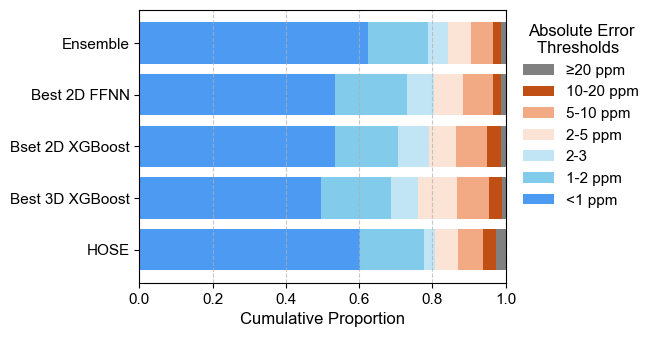

In [218]:
combined_vali['Ensemble_model_HOSE_FFNN'] = np.where(
    combined_vali['similarity_levels'] > 3, 
    combined_vali['HOSE Code'], 
    combined_vali['FFNN 2D_s5']
)

plot_cumulative_stacked_bar(combined_vali, models = ["HOSE Code", "XGBoost 3D_n5", "XGBoost 2D_s5", "FFNN 2D_s5", "Ensemble_model_HOSE_FFNN"], 
                                model_labels = ["HOSE", "Best 3D XGBoost", "Bset 2D XGBoost", "Best 2D FFNN", 'Ensemble'])

# 1.4 An interactive interface to see the prediction error of each model under different similarity levels.

In [12]:
pd.set_option("display.max_rows", 100)

similarity_level_1 = combined_vali[combined_vali['similarity_levels'] == 1]
similarity_level_1.head(100)

,Unnamed: 0,actual,HOSE Code,similarity_levels,XGBoost 3D_n5,XGBoost 2D_s5,FFNN 2D_s5,Ensemble_model_HOSE_FFNN
326,4_From_Review_446,-155.0,46.565420,1,1.851242,20.092712,13.969452,13.969452
521,0_From_Review_278,-5.1,103.334580,1,31.538252,20.066468,14.802508,14.802508
522,2_From_Review_278,-5.1,103.334580,1,31.538252,20.066468,14.802508,14.802508
523,3_From_Review_278,-5.1,103.334580,1,31.538252,20.066468,14.802508,14.802508
1106,0_From_Review_13,-70.0,38.326042,1,1.828316,2.192535,0.715454,0.715454
1107,2_From_Review_13,-70.0,38.326042,1,1.969810,2.192535,0.715454,0.715454
1124,0_From_Review_14,-73.0,35.326042,1,0.412956,5.192535,3.232986,3.232986
1125,2_From_Review_14,-73.0,35.326042,1,0.660530,5.192535,3.232986,3.232986
1198,4_From_Review_442,-145.0,36.673958,1,35.521988,12.695877,4.704697,4.704697
1543,0_From_Review_277,-18.0,89.863245,1,8.495068,7.629006,6.406321,6.406321


In [13]:
def plot_data_points(vali_data, train_data, similarity_level, show_HOSE = True, show_XGBoost_2D = True, show_XGBoost_3D = True, FFNN_2D = True):
    if train_data is not None:
        plt.plot(
        train_data['actual'], 
        train_data['FFNN 2D_s5'], 
        label='Train (2D FFNN)', 
         color='grey',
         alpha=0.2,
         marker = 'o'
         )
            
    similarity_level_n = vali_data[vali_data['similarity_levels'] == similarity_level]
    if show_HOSE:
        plt.plot(
            similarity_level_n['actual'], 
            similarity_level_n['HOSE Code'], 
            label='HOSE Code', 
            color='#1b9e77',
            alpha=0.7,
            marker = '>'
        )
    if show_XGBoost_3D:
        plt.plot(
            similarity_level_n['actual'], 
            similarity_level_n['XGBoost 3D_n5'], 
            label='XGBoost 3D_n5', 
            color='#d95f02',
            alpha=0.7,
            marker = 's',
        )
    if show_XGBoost_2D:
        plt.plot(
            similarity_level_n['actual'], 
            similarity_level_n['XGBoost 2D_s5'], 
            label='XGBoost 2D_s5', 
            color='#7570b3',
            alpha=0.7,
            marker = 'x',
        )
    if FFNN_2D:
        plt.plot(
            similarity_level_n['actual'], 
            similarity_level_n['FFNN 2D_s5'], 
            label='FFNN 2D_s5', 
            color='#e7298a',
            alpha=0.7,
            marker = 'D',
        )
    plt.legend()

In [14]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

class PlotInterface:
    def __init__(self, combined_vali, combined_train, vali_split_points, plot_data_points):
        self.combined_vali = combined_vali
        self.combined_train = combined_train
        self.vali_split_points = vali_split_points
        self.plot_data_points = plot_data_points
        
        # Create widgets
        self.create_widgets()
        self.setup_interface()
        
    def create_widgets(self):
        # Dataset index selector
        self.dataset_selector = widgets.Dropdown(
            options=[(f'Dataset {i} (Seed {i})', i) for i in range(5)],
            value=0,
            description='Dataset:',
            style={'description_width': 'initial'}
        )
        
        # Similarity level selector
        self.similarity_selector = widgets.Dropdown(
            options=[(f'Level {i}', i) for i in range(1, 5)],
            value=4,
            description='Similarity Level:',
            style={'description_width': 'initial'}
        )
        
        # Model toggles
        self.hose_toggle = widgets.Checkbox(
            value=True,
            description='Show HOSE',
            style={'description_width': 'initial'}
        )
        
        self.xgboost_2d_toggle = widgets.Checkbox(
            value=True,
            description='Show XGBoost 2D',
            style={'description_width': 'initial'}
        )
        
        self.xgboost_3d_toggle = widgets.Checkbox(
            value=True,
            description='Show XGBoost 3D',
            style={'description_width': 'initial'}
        )
        
        self.ffnn_2d_toggle = widgets.Checkbox(
            value=True,
            description='Show FFNN 2D',
            style={'description_width': 'initial'}
        )
        
        # Generate plot button
        self.plot_button = widgets.Button(
            description='Generate Plot',
            button_style='primary',
            tooltip='Click to generate plot with current settings',
            icon='chart-line'
        )
        
        # Output area for plots
        self.output = widgets.Output()
        
    def setup_interface(self):
        # Set up event handlers
        self.plot_button.on_click(self.generate_plot)
        
        # Auto-update on parameter change (optional - comment out if you prefer manual updates)
        self.dataset_selector.observe(self.on_parameter_change, names='value')
        self.similarity_selector.observe(self.on_parameter_change, names='value')
        self.hose_toggle.observe(self.on_parameter_change, names='value')
        self.xgboost_2d_toggle.observe(self.on_parameter_change, names='value')
        self.xgboost_3d_toggle.observe(self.on_parameter_change, names='value')
        self.ffnn_2d_toggle.observe(self.on_parameter_change, names='value')
        
    def on_parameter_change(self, change):
        """Auto-generate plot when parameters change"""
        self.generate_plot()
        
    def generate_plot(self, button=None):
        """Generate plot with current parameters"""
        with self.output:
            clear_output(wait=True)
            
            # Get current parameter values
            i = self.dataset_selector.value
            similarity_level = self.similarity_selector.value
            show_HOSE = self.hose_toggle.value
            show_XGBoost_2D = self.xgboost_2d_toggle.value
            show_XGBoost_3D = self.xgboost_3d_toggle.value
            FFNN_2D = self.ffnn_2d_toggle.value
            
            # Calculate data indices
            start_idx = self.vali_split_points[i]
            end_idx = self.vali_split_points[i+1]
            
            print(f"Generating plot for:")
            print(f"  Dataset: {i} (indices {start_idx}:{end_idx})")
            print(f"  Similarity Level: {similarity_level}")
            print(f"  Models: HOSE={show_HOSE}, XGBoost_2D={show_XGBoost_2D}, XGBoost_3D={show_XGBoost_3D}, FFNN_2D={FFNN_2D}")
            print("-" * 50)
            
            try:
                # Call your plotting function
                self.plot_data_points(
                    vali_data=self.combined_vali[start_idx:end_idx],
                    train_data=self.combined_train[start_idx:end_idx],
                    similarity_level=similarity_level,
                    show_HOSE=show_HOSE,
                    show_XGBoost_2D=show_XGBoost_2D,
                    show_XGBoost_3D=show_XGBoost_3D,
                    FFNN_2D=FFNN_2D
                )
                plt.show()
                
            except Exception as e:
                print(f"Error generating plot: {str(e)}")
                
    def display(self):
        """Display the interface"""
        # Create layout
        controls_box = widgets.VBox([
            widgets.HTML("<h3>Plot Parameters</h3>"),
            widgets.HBox([self.dataset_selector, self.similarity_selector]),
            widgets.HTML("<h4>Models to Display</h4>"),
            widgets.VBox([
                self.hose_toggle,
                self.xgboost_2d_toggle,
                self.xgboost_3d_toggle,
                self.ffnn_2d_toggle
            ]),
            self.plot_button
        ])
        
        # Main interface
        interface = widgets.VBox([
            controls_box,
            widgets.HTML("<hr>"),
            self.output
        ])
        
        display(interface)
        
        # Generate initial plot
        self.generate_plot()

# Usage in your notebook:
# Create and display the interface
plot_interface = PlotInterface(
    combined_vali=combined_vali,
    combined_train=combined_train, 
    vali_split_points=vali_split_points,
    plot_data_points=plot_data_points
)

plot_interface.display()

# 1.5 Data insights

* Why HOSE model cannot accurately predict F atoms with high similarity? How does ML perform on these data?

    For HOSE code with similarity_level being >= 4, the std of its shift should be below 2 ppm, above 5 are unusual data which we want to look at. 

    For HOSE code with similarity_level being 3, the std of its shift should be below 5 ppm, above 10 are unusual data which we want to look at. 

* Why ML performs well for F atoms with low similarity?
    For HOSE code with similarity_level being 2 and 1, the std of its shift are high, we want to look at data with error above 10 ppm, and see how does ML perform on these data.

* For F atoms with similarity_level >= 4, we want to look at data with error below 2 ppm, and see the structure pattern of these F atoms.

## 1.5.1 Radii >= 3

In [543]:
# 
# Get the HOSE code for the full train dataset
# 

data_path = os.path.join("..", "dataset", "Processed_PFAS_19F_NMR_spectra_data.csv")
All_fluorinated_compounds = pd.read_csv(data_path)
train_dataset, test_fluorinated_compounds = common.split_datasets(All_fluorinated_compounds, RANDOM_STATE=RANDOM_STATE, verbose = True)
HOSE_database_full_version = hose_code.getHoseCodeContent(train_dataset)
HOSE_database_full_version.head()

Number of fluorinated compounds in the train and test datasets are 549 and 98 respectively.
Ratio of PFAS in the train and test datasets are 0.61 and 1.00 respectively.


[13:33:18] UFFTYPER: Warning: hybridization set to SP3 for atom 6


,0,1,2,3,4,5,NMR_Peaks
9_From_Review_182,F-1;C(//),F-1;C(=CC//),"F-1;C(=CC/\C,=OO/)","F-1;C(=CC/\C,=OO/C,,C)","F-1;C(=CC/\C,=OO/C,,C)C,CCC/","F-1;C(=CC/\C,=OO/C,,C)C,CCC/C,,,/",-121.3
5_From_Review_230,F-1;C(//),F-1;C(OF//),"F-1;C(OF/S,/)","F-1;C(OF/S,/=O=OC)","F-1;C(OF/S,/=O=OC),,FFF/","F-1;C(OF/S,/=O=OC),,FFF/,,/",-83.0
6_From_Review_230,F-1;C(//),F-1;C(OF//),"F-1;C(OF/S,/)","F-1;C(OF/S,/=O=OC)","F-1;C(OF/S,/=O=OC),,FFF/","F-1;C(OF/S,/=O=OC),,FFF/,,/",-83.0
8_From_Review_230,F-1;C(//),F-1;C(SFF//),"F-1;C(SFF/=O=OO,,/)","F-1;C(SFF/=O=OO,,/,,C)","F-1;C(SFF/=O=OO,,/,,C)FF/","F-1;C(SFF/=O=OO,,/,,C)FF/,/",NaN
9_From_Review_230,F-1;C(//),F-1;C(SFF//),"F-1;C(SFF/=O=OO,,/)","F-1;C(SFF/=O=OO,,/,,C)","F-1;C(SFF/=O=OO,,/,,C)FF/","F-1;C(SFF/=O=OO,,/,,C)FF/,/",NaN


In [560]:
#
# For each F atom configuration (radii = 4, i.e., column = 3), get the count, mean, std, min, and max values of NMR shifts
#
HOSE_database_full_version.dropna(subset=['NMR_Peaks'], inplace=True)
HOSE_database_full_version['NMR_Peaks'] = HOSE_database_full_version['NMR_Peaks'].apply(pd.to_numeric)

radii_4 = HOSE_database_full_version.groupby(3)['NMR_Peaks'].agg(['count', 'mean', 'std', 'min', 'max']).sort_values(by='count', ascending=False)
radii_4

,count,mean,std,min,max
3,,,,,
"F-1;C(CCF/C,C,FF,FF,/C,C,FF,FF,,,,)",332,-122.377398,0.642732,-123.95,-120.83
"F-1;C(CFF/CFF,,/CFF,,)",324,-81.306852,0.803727,-83.19,-78.00
"F-1;C(CCF/CFF,FFF,/CFF,,,,,)",175,-126.489143,0.579497,-127.56,-125.40
"F-1;C(CCF/C,CFF,FF,/CFF,FFF,,,,)",116,-123.420862,0.724494,-124.83,-122.07
"F-1;C(CCF/C,C,FF,FF,/CFF,C,,,,)",48,-121.856667,1.514766,-123.40,-115.19
...,...,...,...,...,...
"F-1;C(=CI/\F,/)",1,-109.000000,NaN,-109.00,-109.00
"F-1;C(=CI/\C\F,/*C*C,)",1,-101.000000,NaN,-101.00,-101.00
"F-1;C(=CCl/|F|Cl,/,)",1,-106.000000,NaN,-106.00,-106.00


In [561]:
# Get the F atom configurations (radii = 4) with more than 1 standard deviation.
# According to our previous analysis, these configurations should have std below 1.0 ppm.
radii_4_std_above_1 = radii_4[radii_4['std'] > 1]
radii_4_std_above_2 = radii_4[radii_4['std'] > 2]
radii_4_std_above_5 = radii_4[radii_4['std'] > 5]
print(f'There are {len(radii_4_std_above_1)} F atom configurations (radii = 4) with std above 1 ppm.')
print(f'There are {len(radii_4_std_above_2)} F atom configurations (radii = 4) with std above 2 ppm.')
print(f'There are {len(radii_4_std_above_5)} F atom configurations (radii = 4) with std above 5 ppm.')

radii_4_std_above_5.head(3)

There are 57 F atom configurations (radii = 4) with std above 1 ppm.
There are 42 F atom configurations (radii = 4) with std above 2 ppm.
There are 11 F atom configurations (radii = 4) with std above 5 ppm.


,count,mean,std,min,max
3,,,,,
"F-1;C(*C*C/*C,*C,F,F/*C,*&,F,F,,)",11,-160.483636,9.560002,-173.95,-143.2
F-1;C(C/=C/\C),6,-212.500000,6.058052,-224.00,-208.0
"F-1;C(=CF/SF,/C,)",2,-94.500000,13.435029,-104.00,-85.0


There are 57 structures (radii = 4) show NMR shifts with std more than 1 ppm. We will look into these structures to see if they are outliers or not.

In [ ]:
#
# Ouput csv files
#

def get_PFAS_info_with_HOSE_radii(hose, original_dataset=All_fluorinated_compounds, similarity_level=4):
    """
    Show the PFAS information with the given HOSE code and similarity_level.
    Args:
        hose (str): The HOSE code to search for.
        original_dataset (pd.DataFrame): The original dataset containing PFAS information.
        similarity_level (int): The similarity_level of the HOSE code to search for.
    Returns:
        None or pd.DataFrame: If less than 5 F atoms are found, return None. Otherwise, return a DataFrame containing the PFAS information.
    """
    hose_subset = HOSE_database_full_version[HOSE_database_full_version[similarity_level - 1] == hose]

    pfas_name_list = hose_subset.index
    shifts = hose_subset['NMR_Peaks'].values
    avg_shift = np.mean(shifts)
    std_shifts = np.std(shifts)
    min_shifts = np.min(shifts)
    max_shifts = np.max(shifts)
    num_F_atoms = len(pfas_name_list)

    pfas_codes = []
    shift_values = []
    smiles_string = []
    F_atom_idxs = []
    XGboost_2D_predictions = []
    XGBoost_3D_predictions = []
    FFNN_2D_predictions = []
    hose_predictions = []

    for pfas_name, chemical_shift in zip(pfas_name_list, shifts):
        F_atom_idx = pfas_name.split('_')[0]
        pfas_code = pfas_name.replace(F_atom_idx + '_', '')

        pfas_codes.append(pfas_code)
        F_atom_idxs.append(F_atom_idx)
        shift_values.append(chemical_shift)
        smiles_string.append(original_dataset[original_dataset['Code'] == pfas_code]['SMILES'].values[0])

        pred_row = combined_vali_with_predicted_shifts[combined_vali_with_predicted_shifts['Unnamed: 0'] == pfas_name]
        xgb2d = pred_row['XGBoost 2D_s5'].values
        xgb3d = pred_row['XGBoost 3D_n5'].values
        ffnn2d = pred_row['FFNN 2D_s5'].values
        hosecode = pred_row['HOSE Code'].values

        if xgb2d.size > 0 and xgb3d.size > 0 and ffnn2d.size > 0:
            XGboost_2D_predictions.append(xgb2d[0])
            XGBoost_3D_predictions.append(xgb3d[0])
            FFNN_2D_predictions.append(ffnn2d[0])
            hose_predictions.append(hosecode[0])

        else:
            XGboost_2D_predictions.append('NaN')
            XGBoost_3D_predictions.append('NaN')
            FFNN_2D_predictions.append('NaN')
            hose_predictions.append('NaN')

    result_df = pd.DataFrame({
        'PFAS_code': pfas_codes,
        'SMILES': smiles_string,
        'F_atom_idx': F_atom_idxs,
        'NMR_shift': shift_values,
        'XGBoost_2D_prediction': XGboost_2D_predictions,
        'XGBoost_3D_prediction': XGBoost_3D_predictions,
        'FFNN_2D_prediction': FFNN_2D_predictions,
        'HOSE_prediction': hose_predictions
    })

    result_df['HOSE_code'] = hose
    result_df['radii'] = similarity_level
    result_df['num_F_atoms'] = num_F_atoms
    result_df['avg_shift'] = avg_shift
    result_df['std_shifts'] = std_shifts
    result_df['min_shifts'] = min_shifts
    result_df['max_shifts'] = max_shifts

    return result_df

#
for similarity_level in [5, 4, 3, 2, 1]:
    radii_n = HOSE_database_full_version.groupby(similarity_level-1)['NMR_Peaks'].agg(['count', 'mean', 'std', 'min', 'max']).sort_values(by='count', ascending=False)
    
    # Since the number of F atoms with similarity_level > 2 is big, we want to filter out those with count < 5.
    if similarity_level > 2:
        radii_n = radii_n[radii_n['count'] >= 2]

    # Get the F atom configurations with std above the thresholds
    radii_n_std_above_2 = radii_n[radii_n['std'] > 2]
    radii_n_std_above_5 = radii_n[radii_n['std'] > 5]
    radii_n_std_above_10 = radii_n[radii_n['std'] > 10]

    # Get the list of HOSE codes for each threshold range
    hose_n_with_std_above_10 = radii_n_std_above_10.index.values
    hose_n_with_std_between_5_10 = [r for r in radii_n_std_above_5.index if r not in radii_n_std_above_10.index]
    hose_n_with_std_below_2 = [r for r in radii_n.index if r not in radii_n_std_above_2.index]

    dataset_options = {
        "< 2 ppm": hose_n_with_std_below_2,
        "5-10 ppm": hose_n_with_std_between_5_10,
        "> 10 ppm": hose_n_with_std_above_10
    }

    concated_df = pd.DataFrame()
    for key, hose_codes in dataset_options.items():
        for hose in hose_codes:
            result_df = get_PFAS_info_with_HOSE_radii(hose, original_dataset=All_fluorinated_compounds, similarity_level=similarity_level)
            if result_df is not None:
                result_df['error_threshold'] = key
                concated_df = pd.concat([concated_df, result_df], ignore_index=True)
                
    # Save the results to a CSV file
    output_file = f"PFAS_HOSE_code_radii_{similarity_level}_error_thresholds.xlsx"
    file_path = os.path.join("..", "artifacts", "results", output_file)
    concated_df.to_excel(file_path, index=True)
    print(f"Results saved to {file_path}")

Results saved to ../artifacts/results/PFAS_HOSE_code_radii_5_error_thresholds.xlsx
Results saved to ../artifacts/results/PFAS_HOSE_code_radii_4_error_thresholds.xlsx
Results saved to ../artifacts/results/PFAS_HOSE_code_radii_3_error_thresholds.xlsx
Results saved to ../artifacts/results/PFAS_HOSE_code_radii_2_error_thresholds.xlsx
Results saved to ../artifacts/results/PFAS_HOSE_code_radii_1_error_thresholds.xlsx


In [575]:
PFAS_HOSE_code_radii_5_error_thresholds = pd.read_excel(os.path.join("..", "artifacts", "results", "PFAS_HOSE_code_radii_5_error_thresholds.xlsx"), index_col=0)
PFAS_HOSE_code_radii_4_error_thresholds = pd.read_excel(os.path.join("..", "artifacts", "results", "PFAS_HOSE_code_radii_4_error_thresholds.xlsx"), index_col=0)
PFAS_HOSE_code_radii_3_error_thresholds = pd.read_excel(os.path.join("..", "artifacts", "results", "PFAS_HOSE_code_radii_3_error_thresholds.xlsx"), index_col=0)
PFAS_HOSE_code_radii_2_error_thresholds = pd.read_excel(os.path.join("..", "artifacts", "results", "PFAS_HOSE_code_radii_2_error_thresholds.xlsx"), index_col=0)
PFAS_HOSE_code_radii_1_error_thresholds = pd.read_excel(os.path.join("..", "artifacts", "results", "PFAS_HOSE_code_radii_1_error_thresholds.xlsx"), index_col=0)

# Only keep rows with ML model predictions
PFAS_HOSE_code_radii_5_error_thresholds.dropna(how = 'any', axis=0, inplace=True)
PFAS_HOSE_code_radii_4_error_thresholds.dropna(how = 'any', axis=0, inplace=True)
PFAS_HOSE_code_radii_3_error_thresholds.dropna(how = 'any', axis=0, inplace=True)
PFAS_HOSE_code_radii_2_error_thresholds.dropna(how = 'any', axis=0, inplace=True)
PFAS_HOSE_code_radii_1_error_thresholds.dropna(how = 'any', axis=0, inplace=True)

print(f'Shape of PFAS_HOSE_code_radii_4_error_thresholds: {PFAS_HOSE_code_radii_4_error_thresholds.shape}')
PFAS_HOSE_code_radii_4_error_thresholds.head(3) 

Shape of PFAS_HOSE_code_radii_4_error_thresholds: (1665, 16)


,PFAS_code,SMILES,F_atom_idx,NMR_shift,XGBoost_2D_prediction,XGBoost_3D_prediction,FFNN_2D_prediction,HOSE_prediction,HOSE_code,radii,num_F_atoms,avg_shift,std_shifts,min_shifts,max_shifts,error_threshold
4,alcohols_7,OCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,9,-122.44,-122.74023,-123.08761,-122.886566,-122.388793,"F-1;C(CCF/C,C,FF,FF,/C,C,FF,FF,,,,)",4,332,-122.377398,0.641763,-123.95,-120.83,< 2 ppm
5,alcohols_7,OCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,10,-122.44,-122.74023,-122.67748,-122.886566,-122.388793,"F-1;C(CCF/C,C,FF,FF,/C,C,FF,FF,,,,)",4,332,-122.377398,0.641763,-123.95,-120.83,< 2 ppm
6,alcohols_7,OCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,12,-122.91,-122.50487,-122.82009,-122.470140,-122.782414,"F-1;C(CCF/C,C,FF,FF,/C,C,FF,FF,,,,)",4,332,-122.377398,0.641763,-123.95,-120.83,< 2 ppm


In [577]:
PFAS_HOSE_code_radii_5_error_thresholds.drop_duplicates(subset=['HOSE_code'], inplace=True)
PFAS_HOSE_code_radii_4_error_thresholds.drop_duplicates(subset=['HOSE_code'], inplace=True)
PFAS_HOSE_code_radii_3_error_thresholds.drop_duplicates(subset=['HOSE_code'], inplace=True)

print(f'Shape of PFAS_HOSE_code_radii_5_error_thresholds after dropping duplicates: {PFAS_HOSE_code_radii_5_error_thresholds.shape}')
print(f'Shape of PFAS_HOSE_code_similarity_level_4_error_thresholds after dropping duplicates: {PFAS_HOSE_code_radii_4_error_thresholds.shape}')
print(f'Shape of PFAS_HOSE_code_similarity_level_3_error_thresholds after dropping duplicates: {PFAS_HOSE_code_radii_3_error_thresholds.shape}') 

Shape of PFAS_HOSE_code_radii_5_error_thresholds after dropping duplicates: (354, 16)
Shape of PFAS_HOSE_code_similarity_level_4_error_thresholds after dropping duplicates: (246, 16)
Shape of PFAS_HOSE_code_similarity_level_3_error_thresholds after dropping duplicates: (119, 16)


In [578]:
PFAS_HOSE_code_radii_5_error_thresholds.head(3)

,PFAS_code,SMILES,F_atom_idx,NMR_shift,XGBoost_2D_prediction,XGBoost_3D_prediction,FFNN_2D_prediction,HOSE_prediction,HOSE_code,radii,num_F_atoms,avg_shift,std_shifts,min_shifts,max_shifts,error_threshold
3,alcohols_7,OCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,21,-80.98,-81.644424,-81.06175,-81.17294,-81.288163,"F-1;C(CFF/CFF,,/CFF,,)CFF,,/",5,267,-81.382135,0.780761,-83.19,-79.95,< 2 ppm
269,alcohols_7,OCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,18,-126.28,-125.898310,-125.94074,-126.33941,-126.482000,"F-1;C(CCF/CFF,FFF,/CFF,,,,,)CFF,,/",5,139,-126.453669,0.553658,-127.49,-125.40,< 2 ppm
406,I_7,FC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,14,-121.77,-122.463070,-122.22025,-122.57439,-121.890000,"F-1;C(CCF/C,C,FF,FF,/C,C,FF,FF,,,,)C,C,FF,FF,,,,/",5,126,-122.146794,0.486361,-123.73,-121.64,< 2 ppm


In [579]:
PFAS_HOSE_code_radii_5_error_thresholds.to_excel('temp_PFAS_HOSE_code_similarity_level_5_error_thresholds.xlsx', index=False)
PFAS_HOSE_code_radii_4_error_thresholds.to_excel('temp_PFAS_HOSE_code_similarity_level_4_error_thresholds.xlsx', index=False)
PFAS_HOSE_code_radii_3_error_thresholds.to_excel('temp_PFAS_HOSE_code_similarity_level_3_error_thresholds.xlsx', index=False)

## 1.5.2 Show PFAS information with HOSE code and various error thresholds

In [571]:
def show_PFAS_info_with_HOSE_radii(hose, original_dataset=All_fluorinated_compounds, similarity_level=4):
    """
    Show the PFAS information with the given HOSE code and radii.
    Args:
        hose (str): The HOSE code to search for.
        original_dataset (pd.DataFrame): The original dataset containing PFAS information.
        similarity_level (int): The similarity_level of the HOSE code to search for.
    Returns:
        None or pd.DataFrame: If less than 5 F atoms are found, return None. Otherwise, return a DataFrame containing the PFAS information.
    """
    hose_subset = HOSE_database_full_version[HOSE_database_full_version[similarity_level - 1] == hose]
    print('>>>>>>>>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<<<<<<<<<<')
    print(f'\nThe following molecule has F atoms with HOSE code with radii = {similarity_level} being {hose}. ')

    pfas_name_list = hose_subset.index
    shifts = hose_subset['NMR_Peaks'].values
    avg_shift = np.mean(shifts)
    std_shifts = np.std(shifts)
    min_shifts = np.min(shifts)
    max_shifts = np.max(shifts)
    num_F_atoms = len(pfas_name_list)
    print(f'The number of F atoms with this HOSE code is: {num_F_atoms}')
    print(f'The NMR shifts for these F atoms are in the range of {min_shifts:.2f} ppm to {max_shifts:.2f} ppm.')
    print(f'The average and standard deviation of NMR shift for these F atoms is: {avg_shift:.2f} ± {std_shifts:.2f} ppm.')
    
    pfas_codes = []
    shift_values = []
    smiles_string = []
    F_atom_idxs = []
    XGboost_2D_predictions = []
    XGBoost_3D_predictions = []
    FFNN_2D_predictions = []
    hose_predictions = []

    for pfas_name, chemical_shift in zip(pfas_name_list, shifts):
        F_atom_idx = pfas_name.split('_')[0]
        pfas_code = pfas_name.replace(F_atom_idx + '_', '')

        pfas_codes.append(pfas_code)
        F_atom_idxs.append(F_atom_idx)
        shift_values.append(chemical_shift)
        smiles_string.append(original_dataset[original_dataset['Code'] == pfas_code]['SMILES'].values[0])

        pred_row = combined_vali_with_predicted_shifts[combined_vali_with_predicted_shifts['Unnamed: 0'] == pfas_name]
        xgb2d = pred_row['XGBoost 2D_s5'].values
        xgb3d = pred_row['XGBoost 3D_n5'].values
        ffnn2d = pred_row['FFNN 2D_s5'].values
        hosecode = pred_row['HOSE Code'].values

        if xgb2d.size > 0 and xgb3d.size > 0 and ffnn2d.size > 0:
            XGboost_2D_predictions.append(xgb2d[0])
            XGBoost_3D_predictions.append(xgb3d[0])
            FFNN_2D_predictions.append(ffnn2d[0])
            hose_predictions.append(hosecode[0])

        else:
            XGboost_2D_predictions.append('NaN')
            XGBoost_3D_predictions.append('NaN')
            FFNN_2D_predictions.append('NaN')
            hose_predictions.append('NaN')

    result_df = pd.DataFrame({
        'PFAS_code': pfas_codes,
        'SMILES': smiles_string,
        'F_atom_idx': F_atom_idxs,
        'NMR_shift': shift_values,
        'XGBoost_2D_prediction': XGboost_2D_predictions,
        'XGBoost_3D_prediction': XGBoost_3D_predictions,
        'FFNN_2D_prediction': FFNN_2D_predictions,
        'HOSE_prediction': hose_predictions
    })

    for pfas_code in result_df['PFAS_code'].unique():
        show_image([pfas_code])
        F_atoms = result_df[result_df['PFAS_code'] == pfas_code]['F_atom_idx'].values
        print(f'\nThe PFAS code is: {pfas_code}')
        print(f'The F atom indices are: {F_atoms}')
        shifts = result_df[result_df['PFAS_code'] == pfas_code]['NMR_shift'].values
        print(f'Corresponding NMR shifts for these F atoms are: {shifts}')
        print(f'The SMILES for the molecule is: {result_df[result_df["PFAS_code"] == pfas_code]["SMILES"].values[0]}')
        print(f'XGBoost 2D prediction: {result_df[result_df["PFAS_code"] == pfas_code]["XGBoost_2D_prediction"].values}')
        print(f'XGBoost 3D prediction: {result_df[result_df["PFAS_code"] == pfas_code]["XGBoost_3D_prediction"].values}')
        print(f'FFNN 2D prediction: {result_df[result_df["PFAS_code"] == pfas_code]["FFNN_2D_prediction"].values}')
        print(f'HOSE Code prediction: {result_df[result_df["PFAS_code"] == pfas_code]["HOSE_prediction"].values}')    

    print('>>>>>>>>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<<<<<<<<<<')

In [572]:
hose_with_std_above_5 = radii_4_std_above_5.index.values
hose_with_std_between_2_5 = [r for r in radii_4_std_above_2.index if r not in radii_4_std_above_5.index]
hose_with_std_between_1_2 = [r for r in radii_4_std_above_1.index if r not in radii_4_std_above_2.index]
hose_with_std_below_1 = [r for r in radii_4.index if r not in radii_4_std_above_1.index]

print(f'Number of F atom configurations (similarity_level = 4) with std above 5 ppm: {len(hose_with_std_above_5)}')
print(f'Number of F atom configurations (similarity_level = 4) with std between 2 and 5 ppm: {len(hose_with_std_between_2_5)}')
print(f'Number of F atom configurations (similarity_level = 4) with std between 1 and 2 ppm: {len(hose_with_std_between_1_2)}')
print(f'Number of F atom configurations (similarity_level = 4) with std below 1 ppm: {len(hose_with_std_below_1)}')

# idx = 25
# show_PFAS_info_with_radii_4_HOSE(hose_with_std_between_2_5[idx])

Number of F atom configurations (similarity_level = 4) with std above 5 ppm: 11
Number of F atom configurations (similarity_level = 4) with std between 2 and 5 ppm: 31
Number of F atom configurations (similarity_level = 4) with std between 1 and 2 ppm: 15
Number of F atom configurations (similarity_level = 4) with std below 1 ppm: 522


In [573]:
import ipywidgets as widgets
from IPython.display import display, clear_output
def Interface_show_F_configurations(similarity_level, dataset_options):
    """
    Interface to show PFAS information based on selected HOSE code configurations.
    Args:
        similarity_level (int): The radius for HOSE code configurations.
        dataset_options (dict): A dictionary mapping standard deviation values to lists of PFAS codes.
        example:
            dataset_options = {
                        "< 1 ppm": hose_with_std_below_1,
                        "1-2 ppm": hose_with_std_between_1_2,
                        "2-5 ppm": hose_with_std_between_2_5,
                        "> 5 ppm": hose_with_std_above_5
                    }
    """
    # Mapping selection to actual lists

    default_value = list(dataset_options.keys())[-1]  # Default to the first key in the dictionary
    default_list = dataset_options[default_value]

    # Dropdown menu for dataset selection
    dataset_selector = widgets.Dropdown(
        options=list(dataset_options.keys()),
        value=default_value,
        description='Standard Deviation Value:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='300px')
    )

    # Slider for index, will be updated based on selected dataset
    index_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(default_list) - 1,
        step=1,
        description='Select an index to show an example:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='500px')
    )

    # Output area to display function results
    output = widgets.Output()

    # Function to update the slider range based on dataset selection
    def update_slider_range(change):
        selected_list = dataset_options[change['new']]
        index_slider.max = len(selected_list) - 1
        index_slider.value = 0

    dataset_selector.observe(update_slider_range, names='value')

    # Function to call when button is clicked or values change
    def on_change(change=None):
        output.clear_output()
        with output:
            selected_list = dataset_options[dataset_selector.value]
            idx = index_slider.value
            hose = selected_list[idx]
            show_PFAS_info_with_HOSE_radii(hose, similarity_level = similarity_level)

    # Call on_change when either control changes
    dataset_selector.observe(on_change, names='value')
    index_slider.observe(on_change, names='value')

    # Display the UI
    display(widgets.VBox([dataset_selector, index_slider, output]))

    # Initial call
    on_change()

In [574]:
dataset_options = {
    "< 1 ppm": hose_with_std_below_1,
    "1-2 ppm": hose_with_std_between_1_2,
    "2-5 ppm": hose_with_std_between_2_5,
    "> 5 ppm": hose_with_std_above_5
}
# Show the interface for similarity_level = 4
Interface_show_F_configurations(similarity_level=4, dataset_options=dataset_options)

Yes, while HOSE code model cannot predict the NMR shifts of F atoms on C=C, the XGBoost and FFNN models can predict the NMR shifts of these F atoms.

## 1.5.3 Similarity level = 5 data insights

In [580]:
radii_5 = HOSE_database_full_version.groupby(4)['NMR_Peaks'].agg(['count', 'mean', 'std', 'min', 'max']).sort_values(by='count', ascending=False)
radii_5_std_above_1 = radii_5[radii_5['std'] > 1]
radii_5_std_above_2 = radii_5[radii_5['std'] > 2]
radii_5_std_above_5 = radii_5[radii_5['std'] > 5]
radii_5_std_above_10 = radii_5[radii_5['std'] > 10]
print(f'There are {len(radii_5) - len(radii_5_std_above_1)} F atom configurations (radii = 5) with std below 1 ppm.')
print(f'There are {len(radii_5_std_above_1)} F atom configurations (radii = 5) with std above 1 ppm.')
print(f'There are {len(radii_5_std_above_2)} F atom configurations (radii = 5) with std above 2 ppm.')
print(f'There are {len(radii_5_std_above_5)} F atom configurations (radii = 5) with std above 5 ppm.')
print(f'There are {len(radii_5_std_above_10)} F atom configurations (radii = 5) with std above 10 ppm.')

print('-------------------')
hose_5_with_std_above_10 = radii_5_std_above_10.index.values
hose_5_with_std_between_5_10 = [r for r in radii_5_std_above_5.index if r not in radii_5_std_above_10.index]
hose_5_with_std_between_2_5 = [r for r in radii_5_std_above_2.index if r not in radii_5_std_above_5.index]
hose_5_with_std_below_2 = [r for r in radii_5.index if r not in radii_5_std_above_2.index]

print(f'Number of F atom configurations (radii = 3) with std above 10 ppm: {len(hose_5_with_std_above_10)}')
print(f'Number of F atom configurations (radii = 3) with std between 5 and 10 ppm: {len(hose_5_with_std_between_5_10)}')
print(f'Number of F atom configurations (radii = 3) with std between 2 and 5 ppm: {len(hose_5_with_std_between_2_5)}')
print(f'Number of F atom configurations (radii = 3) with std below 2 ppm: {len(hose_5_with_std_below_2)}')

radii_5_std_above_5.head(3)

There are 709 F atom configurations (radii = 5) with std below 1 ppm.
There are 36 F atom configurations (radii = 5) with std above 1 ppm.
There are 24 F atom configurations (radii = 5) with std above 2 ppm.
There are 11 F atom configurations (radii = 5) with std above 5 ppm.
There are 7 F atom configurations (radii = 5) with std above 10 ppm.
-------------------
Number of F atom configurations (radii = 3) with std above 10 ppm: 7
Number of F atom configurations (radii = 3) with std between 5 and 10 ppm: 4
Number of F atom configurations (radii = 3) with std between 2 and 5 ppm: 13
Number of F atom configurations (radii = 3) with std below 2 ppm: 721


,count,mean,std,min,max
4,,,,,
"F-1;C(*C*C/*C,*C,F,F/*C,*&,F,F,,)*&C,,/",4,-150.575,6.525016,-159.1,-143.2
"F-1;C(=CC/C,=OO/*C*C,,C)*C,*C,C/",2,-122.000,5.656854,-126.0,-118.0
"F-1;C(=CC/CF,/O,)/",2,-136.000,12.727922,-145.0,-127.0


In [581]:
dataset_options = {
    "< 2 ppm": hose_5_with_std_below_2,
    "2-5 ppm": hose_5_with_std_between_2_5,
    "5-10 ppm": hose_5_with_std_between_5_10,
    "> 10 ppm": hose_5_with_std_above_10
}

Interface_show_F_configurations(similarity_level = 5, dataset_options=dataset_options)

## 1.5.3 Similarity level = 3 data insights

In [127]:
radii_3 = HOSE_database_full_version.groupby(2)['NMR_Peaks'].agg(['count', 'mean', 'std', 'min', 'max']).sort_values(by='count', ascending=False)
radii_3

,count,mean,std,min,max
2,,,,,
"F-1;C(CCF/C,C,FF,FF,/)",648,-122.673265,1.343040,-135.0,-115.03
"F-1;C(CFF/CFF,,/)",351,-81.361880,0.967796,-84.9,-78.00
"F-1;C(CCF/CFF,FFF,/)",215,-126.467349,0.873916,-128.0,-121.00
"F-1;C(CFF/*C*C,,/)",167,-58.198443,4.302964,-63.9,-49.40
"F-1;C(CCF/CFF,C,/)",82,-114.406829,1.436792,-118.0,-111.10
...,...,...,...,...,...
"F-1;C(=CS/FF,C/)",1,-155.000000,NaN,-155.0,-155.00
F-1;C(=P/C/),1,-69.000000,NaN,-69.0,-69.00
F-1;C(C/%C/),1,-218.000000,NaN,-218.0,-218.00


In [128]:
# Get the F atom configurations (radii = 3) with standard deviation of various range.
# According to our previous analysis, these configurations should have std below 1.0 ppm.
radii_3_std_above_1 = radii_3[radii_3['std'] > 1]
radii_3_std_above_2 = radii_3[radii_3['std'] > 2]
radii_3_std_above_5 = radii_3[radii_3['std'] > 5]
radii_3_std_above_10 = radii_3[radii_3['std'] > 10]
print(f'There are {len(radii_3) - len(radii_3_std_above_1)} F atom configurations (radii = 3) with std below 1 ppm.')
print(f'There are {len(radii_3_std_above_1)} F atom configurations (radii = 3) with std above 1 ppm.')
print(f'There are {len(radii_3_std_above_2)} F atom configurations (radii = 3) with std above 2 ppm.')
print(f'There are {len(radii_3_std_above_5)} F atom configurations (radii = 3) with std above 5 ppm.')
print(f'There are {len(radii_3_std_above_10)} F atom configurations (radii = 3) with std above 10 ppm.')

print('-------------------')
hose_3_with_std_above_10 = radii_3_std_above_10.index.values
hose_3_with_std_between_5_10 = [r for r in radii_3_std_above_5.index if r not in radii_3_std_above_10.index]
hose_3_with_std_between_2_5 = [r for r in radii_3_std_above_2.index if r not in radii_3_std_above_5.index]
hose_3_with_std_below_2 = [r for r in radii_3.index if r not in radii_3_std_above_2.index]

print(f'Number of F atom configurations (radii = 3) with std above 10 ppm: {len(hose_3_with_std_above_10)}')
print(f'Number of F atom configurations (radii = 3) with std between 5 and 10 ppm: {len(hose_3_with_std_between_5_10)}')
print(f'Number of F atom configurations (radii = 3) with std between 2 and 5 ppm: {len(hose_3_with_std_between_2_5)}')
print(f'Number of F atom configurations (radii = 3) with std below 2 ppm: {len(hose_3_with_std_below_2)}')

radii_3_std_above_5.head(3)

There are 252 F atom configurations (radii = 3) with std below 1 ppm.
There are 86 F atom configurations (radii = 3) with std above 1 ppm.
There are 69 F atom configurations (radii = 3) with std above 2 ppm.
There are 24 F atom configurations (radii = 3) with std above 5 ppm.
There are 13 F atom configurations (radii = 3) with std above 10 ppm.
-------------------
Number of F atom configurations (radii = 3) with std above 10 ppm: 13
Number of F atom configurations (radii = 3) with std between 5 and 10 ppm: 11
Number of F atom configurations (radii = 3) with std between 2 and 5 ppm: 45
Number of F atom configurations (radii = 3) with std below 2 ppm: 269


,count,mean,std,min,max
2,,,,,
"F-1;C(*C*C/*C,*C,F,F/)",26,-158.364231,9.220702,-173.95,-141.0
"F-1;C(*C*N/*CF,*C/)",17,-84.588235,7.542039,-93.00,-69.0
"F-1;C(*C*C/*CF,*C/)",16,-138.108750,10.259444,-158.00,-116.0


In [168]:
dataset_options = {
    "< 2 ppm": hose_3_with_std_below_2,
    "2-5 ppm": hose_3_with_std_between_2_5,
    "5-10 ppm": hose_3_with_std_between_5_10,
    "> 10 ppm": hose_3_with_std_above_10
}

Interface_show_F_configurations(similarity_level = 3, dataset_options=dataset_options)

# 1.5.4 Similarity level = 2 data insights

In [163]:
# Use the vali prediction results to see similarity level 2 data
radii_2 = combined_vali_with_predicted_shifts[combined_vali_with_predicted_shifts['similarity_levels'] == 2]
radii_2.head(3)

,Unnamed: 0,actual,HOSE Code,similarity_levels,XGBoost 3D_n5,XGBoost 2D_s5,FFNN 2D_s5
19,7_From_Review_233,-107.50,-121.922808,2,-105.91003,-104.254555,-107.820984
20,8_From_Review_233,-107.50,-121.922808,2,-107.15186,-104.254555,-107.820984
33,5_Cl_4,-120.25,-121.922808,2,-123.47796,-125.508240,-125.266330


In [167]:
# Get the F atom configurations (radii = 2) with more than 1 standard deviation.
radii_2['HOSE_error'] = (radii_2['HOSE Code'] - radii_2['actual']).apply(np.abs)

radii_2_err_above_1 = radii_2[radii_2['HOSE_error'] > 1]
radii_2_err_above_2 = radii_2[radii_2['HOSE_error'] > 2]
radii_2_err_above_5 = radii_2[radii_2['HOSE_error'] > 5]
radii_2_err_above_10 = radii_2[radii_2['HOSE_error'] > 10]

print(f'There are {len(radii_2) - len(radii_2_err_above_1)} F atom configurations (similarity_levels = 2) with std below 1 ppm.')
print(f'There are {len(radii_2_err_above_1)} F atom configurations (similarity_levels = 2) with std above 1 ppm.')
print(f'There are {len(radii_2_err_above_2)} F atom configurations (similarity_levels = 2) with std above 2 ppm.')
print(f'There are {len(radii_2_err_above_5)} F atom configurations (similarity_levels = 2) with std above 5 ppm.')
print(f'There are {len(radii_2_err_above_10)} F atom configurations (similarity_levels = 2) with std above 10 ppm.')

print('-------------------')
hose_2_with_std_above_10 = radii_2_err_above_10.index.values
hose_2_with_std_between_5_10 = [r for r in radii_2_err_above_5.index if r not in radii_2_err_above_10.index]
hose_2_with_std_between_2_5 = [r for r in radii_2_err_above_2.index if r not in radii_2_err_above_5.index]
hose_2_with_std_below_2 = [r for r in radii_2.index if r not in radii_2_err_above_2.index]

print(f'Number of F atom configurations (similarity_levels = 2) with std above 10 ppm: {len(hose_2_with_std_above_10)}')
print(f'Number of F atom configurations (similarity_levels = 2) with std between 5 and 10 ppm: {len(hose_2_with_std_between_5_10)}')
print(f'Number of F atom configurations (similarity_levels = 2) with std between 2 and 5 ppm: {len(hose_2_with_std_between_2_5)}')
print(f'Number of F atom configurations (similarity_levels = 2) with std below 2 ppm: {len(hose_2_with_std_below_2)}')

radii_2_err_above_10.head(3)

There are 10 F atom configurations (similarity_levels = 2) with std below 1 ppm.
There are 375 F atom configurations (similarity_levels = 2) with std above 1 ppm.
There are 340 F atom configurations (similarity_levels = 2) with std above 2 ppm.
There are 267 F atom configurations (similarity_levels = 2) with std above 5 ppm.
There are 165 F atom configurations (similarity_levels = 2) with std above 10 ppm.
-------------------
Number of F atom configurations (similarity_levels = 2) with std above 10 ppm: 165
Number of F atom configurations (similarity_levels = 2) with std between 5 and 10 ppm: 102
Number of F atom configurations (similarity_levels = 2) with std between 2 and 5 ppm: 73
Number of F atom configurations (similarity_levels = 2) with std below 2 ppm: 45


,Unnamed: 0,actual,HOSE Code,similarity_levels,XGBoost 3D_n5,XGBoost 2D_s5,FFNN 2D_s5,HOSE_error
19,7_From_Review_233,-107.5,-121.922808,2,-105.91003,-104.254555,-107.820984,14.422808
20,8_From_Review_233,-107.5,-121.922808,2,-107.15186,-104.254555,-107.820984,14.422808
50,8_From_Review_392,-206.0,-182.078947,2,-202.33633,-201.601270,-196.774120,23.921053


# 1.6 Ensemble Model
According to above data analysis, the overall performance of HOSE model is better than ML models for F atoms with similarity level >= 4, While ML models perform better for F atoms with similarity level <= 3.  

We also found that even for F atoms with similarity level >= 4, there are some configurations that HOSE model cannot predict well, including F on C=C, F on aromatic rings, and F near ring structures. 

To build a powerful ensemble model, we can combine the predictions from HOSE and 2D FFNN models.

We can use the HOSE model for F atoms with similarity level >= 4, and use the FFNN model for F atoms with similarity level <= 3. Or, we can add similarity level and HOSE model preditions as features to the FFNN model, and use the FFNN model to predict the NMR shifts for all F atoms.

We will next compare the performance of these two approaches.

## 1.6.1 Approach 1: Use HOSE model for atoms with similarity level >=4 and FFNN model for others

In [414]:
#
# Get the train, and test datasets
#
data_path = os.path.join("..", "dataset", "Processed_PFAS_19F_NMR_spectra_data.csv")
All_fluorinated_compounds = pd.read_csv(data_path)
train_dataset, test_fluorinated_compounds = common.split_datasets(All_fluorinated_compounds, RANDOM_STATE=RANDOM_STATE, verbose = True)

Number of fluorinated compounds in the train and test datasets are 549 and 98 respectively.
Ratio of PFAS in the train and test datasets are 0.61 and 1.00 respectively.


In [391]:
# '''
#     Use the whoile train dataset to re-train 2D FFNN model with the atomic features from 5 neighboring spheres of atoms.
#     Model architecture will be the optimzied one from the previous training.
#     config = 
# '''
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda
# from tensorflow.keras.models import load_model
# from sklearn.preprocessing import StandardScaler
# import random

# # Set All Random Seeds
# np.random.seed(RANDOM_STATE)
# tf.random.set_seed(RANDOM_STATE)
# random.seed(RANDOM_STATE)

# # For TensorFlow deterministic operations
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)

# # Same data preprocessing as for the Ridge model. Therefore we don't have to save relevant imputer, scaler, and column names to files
# class Define_and_Train_FFNN_Model_2D():
#     def __init__(self, num_spheres, dataset):
#         self.num_spheres = num_spheres
#         self.dataset = dataset
#         self.X_train_scaled, self.X_val_scaled, self.y_train, self.y_val = self.step1_data_generation()
#         self.model, self.history = self.step2_create_model(self.X_train_scaled, self.X_val_scaled, self.y_train, self.y_val, 
#                                                            config = {'layers': [128, 64, 32], 'dropout': [0.2, 0.1, 0.0]},
#         )
#         return 

#     def step1_data_generation(self):
#         get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
#         dataset = get_2d_descriptors.getDescriptorsFromDataset(
#             self.dataset, self.num_spheres
#         )

#         # Drop columns with constant values
#         dataset = common.drop_constant_col(dataset)

#         # Drop columns with >80% values being NaN
#         dataset_dropNaN = common.drop_high_ratio_NaN_cols(dataset)
        
#         # drop rows with NaN values in the 'NMR_Peaks' column
#         dataset_dropNaN = dataset_dropNaN.dropna(subset=["NMR_Peaks"])
        
#         # Convert all columns in df to numeric where possible, keeping non-numeric values unchanged
#         dataset_dropNaN = dataset_dropNaN.apply(pd.to_numeric, errors="ignore")
        
#         # Drop categorical columns
#         dataset_dropCat = common.drop_categorical_columns(dataset_dropNaN)

#         # Conver column names to 'string'
#         dataset_dropCat.columns = dataset_dropCat.columns.astype(str)

#         y = dataset_dropCat["NMR_Peaks"]
#         X = dataset_dropCat.drop(["NMR_Peaks"], axis=1)

#          # Split data into training and validation sets
#         X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, shuffle=True)

#         # Impute missing values in the training and validation sets
#         # Fit preprocessing on training data only
#         X_train_imputed, imputer = common.fill_NaN(X_train)
#         # Apply imputation to validation data
#         X_val_imputed = pd.DataFrame(
#             imputer.transform(X_val), 
#             columns=X_val.columns, 
#             index=X_val.index
#         )

#         # Fit scaler on training data only
#         scaler = StandardScaler()
#         X_train_scaled = scaler.fit_transform(X_train_imputed)
#         X_val_scaled = scaler.transform(X_val_imputed)

#         # Convert back to DataFrames
#         X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_imputed.columns, index=X_train.index)
#         X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val_imputed.columns, index=X_val.index)
        
#         # Save preprocessing objects
#         preprocessing_objects = {
#             'imputer': imputer,
#             'scaler': scaler,
#             'columns': X_train_imputed.columns.tolist()
#         }

#         # Save to files
#         self._save_preprocessing_objects(preprocessing_objects)
        
#         return X_train_scaled, X_val_scaled, y_train, y_val

#     def _save_preprocessing_objects(self, preprocessing_objects):
#         """Save preprocessing objects to files"""
#         base_path = os.path.join("..", "artifacts", "models")
        
#         # Save imputer
#         with open(os.path.join(base_path, f"final_2D_FFNN_imputer_2d_sphere{self.num_spheres}.pkl"), "wb") as f:
#             pickle.dump(preprocessing_objects['imputer'], f)
        
#         # Save scaler
#         with open(os.path.join(base_path, f"final_2D_FFNN_scaler_2d_sphere{self.num_spheres}.pkl"), "wb") as f:
#             pickle.dump(preprocessing_objects['scaler'], f)
        
#         # Save column names
#         with open(os.path.join(base_path, f"final_2D_FFNN_column_names_2d_sphere{self.num_spheres}.pkl"), "wb") as f:
#             pickle.dump(preprocessing_objects['columns'], f)

    
#     # Define model architecture
#     # Our training dataset have ~ 2000 samples, and ~100 features.
#     def step2_create_model(self, X_train_scaled, X_val_scaled, y_train, y_val, config):
#         model = Sequential([
#             # Input layer
#             Input(shape=(X_train_scaled.shape[1],)),
#             Dense(config['layers'][0], activation='relu'),
#             BatchNormalization(),
#             Dropout(config['dropout'][0]),

#             Dense(config['layers'][1], activation='relu'),
#             BatchNormalization(),
#             Dropout(config['dropout'][1]),

#             # Hidden layers
#             Dense(config['layers'][2], activation='relu'),
#             BatchNormalization(),
#             Dropout(config['dropout'][2]),
            
#             # Output layer - for regression task
#             Dense(1),
#             Lambda(lambda x:-x) # all 19F NMR values are negative in our dataset
#         ])
        
#         lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=100)
   
#         # Early stopping to prevent overfitting
#         early_stopping = tf.keras.callbacks.EarlyStopping(
#             monitor='val_loss',
#             patience=100,
#             restore_best_weights=True
#         )

#         # Compile model
#         # Use Huber loss for our task, which is less sensitive to outliers. 
#         # For small errors ([error] < delta), it behaves like MSE, and for large errors, it behaves like MAE.
#         model.compile(
#             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#             loss=tf.keras.losses.Huber(delta=20), 
#             metrics=['mean_squared_error', 'mean_absolute_error']
#         )

       
#         # Fit the model
#         history = model.fit(
#             X_train_scaled, y_train,
#             epochs=300,
#             batch_size=32,
#             validation_data=(X_val_scaled, y_val),
#             callbacks=[early_stopping, lr_scheduler],
#             verbose=0
#         )

#         # Evaluate the model on validation data
#         val_loss, val_mse, val_mae = model.evaluate(X_val_scaled, y_val, verbose=0)
#         print(f"Validation Loss (Huber loss): {val_loss:.2f}")
#         print(f"Validation MSE: {val_mse:.2f}")
#         print(f"Validation MAE: {val_mae:.2f}")
        
#         # Visualize training history
#         plt.figure(figsize=(12, 4))
        
#         # Plot training & validation loss
#         plt.subplot(1, 2, 1)
#         plt.plot(history.history['loss'])
#         plt.plot(history.history['val_loss'])
#         plt.title('Model Loss')
#         plt.ylabel('Huber Loss')
#         plt.xlabel('Epoch')
#         plt.legend(['Train', 'Validation'], loc='upper right')

#         # Plot training & validation mean absolute error
#         plt.subplot(1, 2, 2)
#         plt.plot(history.history['mean_squared_error'])
#         plt.plot(history.history['val_mean_squared_error'])
#         plt.title('Mean Squared Error')
#         plt.ylabel('MSE')
#         plt.xlabel('Epoch')
#         plt.legend(['Train', 'Validation'], loc='upper right')
#         plt.tight_layout()
#         plt.show()

#         # Save the model
#         model_path = os.path.join("..", "artifacts", "models", f"final_2D_FFNN_sphere{self.num_spheres}.h5")
#         model.save(model_path)
#         print(f">>>> Model saved to {model_path}")
    
        # return model, history.history

In [392]:
# def test_FINAL_2D_FFNN_model_performance(
#     dataset,
#     num_spheres=5,
#     FFNN_2D_model_path=os.path.join("..", "artifacts", "models", "final_2D_FFNN_sphere5.h5"),
#     scaler_path=os.path.join("..", "artifacts", "models", "final_2D_FFNN_scaler_2d_sphere5.pkl"),
#     imputer_path=os.path.join("..", "artifacts", "models", "final_2D_FFNN_imputer_2d_sphere5.pkl"),
#     columns_path=os.path.join("..", "artifacts", "models", "final_2D_FFNN_column_names_2d_sphere5.pkl"),
#     verbose=True
# ):
#     # Load model and preprocessing objects
#     best_model = load_model(FFNN_2D_model_path)

#     with open(scaler_path, "rb") as f:
#         scaler = pickle.load(f)
#     with open(imputer_path, "rb") as f:
#         imputer = pickle.load(f)
#     with open(columns_path, "rb") as f:
#         train_columns = pickle.load(f)

#     # Get 2D descriptors
#     get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
#     content = get_2d_descriptors.getDescriptorsFromDataset(dataset, num_spheres)

#     # Ensure all values are numeric where possible
#     content = content.apply(pd.to_numeric, errors="ignore")
#     content.columns = content.columns.astype(str)

#     # Drop rows without NMR values
#     content = content.dropna(subset=["NMR_Peaks"])

#     y = content["NMR_Peaks"]
#     X = content.drop(columns=["NMR_Peaks"])

#     # Keep only columns used during training
#     X = X[train_columns]

#     # Impute missing values and scale
#     X_imputed = pd.DataFrame(imputer.transform(X), columns=train_columns, index=X.index)
#     X_scaled = pd.DataFrame(scaler.transform(X_imputed), columns=train_columns, index=X.index)

#     # Predict and evaluate
#     results_table = common.get_results_table(best_model=best_model, X=X_scaled, y=y)

#     if verbose:
#         common.plot_prediction_performance(results_table, figure_title=None)
#         common.show_results_scatter(results_table, figure_title=None)

#     return results_table

In [519]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Lambda
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import random

# Set All Random Seeds
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# For TensorFlow deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)

class Define_and_Train_FFNN_Model_2D():
    def __init__(self, num_spheres, dataset):
        self.num_spheres = num_spheres
        self.dataset = dataset
        self.X_scaled, self.y = self.step1_data_generation()
        self.model, self.history = self.step2_create_model(self.X_scaled, self.y, config = {'layers': [128, 64, 32], 'dropout': [0.2, 0.1, 0.0]})
        return 

    def step1_data_generation(self):
        get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
        dataset = get_2d_descriptors.getDescriptorsFromDataset(
            self.dataset, self.num_spheres
        )

        # Drop columns with constant values
        dataset = common.drop_constant_col(dataset)

        # Drop columns with >80% values being NaN
        dataset_dropNaN = common.drop_high_ratio_NaN_cols(dataset)
        
        # drop rows with NaN values in the 'NMR_Peaks' column
        dataset_dropNaN = dataset_dropNaN.dropna(subset=["NMR_Peaks"])
        
        # Convert all columns in df to numeric where possible, keeping non-numeric values unchanged
        dataset_dropNaN = dataset_dropNaN.apply(pd.to_numeric, errors="ignore")
        
        # Drop categorical columns
        dataset_dropCat = common.drop_categorical_columns(dataset_dropNaN)

        # Conver column names to 'string'
        dataset_dropCat.columns = dataset_dropCat.columns.astype(str)
        dataset_dropCat, imputer = common.fill_NaN(dataset_dropCat)
        # Save imputer
        file_path = os.path.join("..", "artifacts", "models", f"final_imputer_2d_sphere{self.num_spheres}_Ridge.pkl")
        with open(file_path, "wb") as file:
            pickle.dump(imputer, file)

        # Save column names
        columns = dataset_dropCat.columns.tolist()
        file_path = os.path.join(
            "..", "artifacts", "models", f"final_column_names_2d_sphere{self.num_spheres}_Ridge.pkl"
        )
        with open(file_path, "wb") as f:
            pickle.dump(columns, f)

        dataset = dataset_dropCat.copy()
        y_train = dataset["NMR_Peaks"]
        X_train = dataset.drop(["NMR_Peaks"], axis=1)

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)

        # Save the scaler to a file
        file_path = os.path.join("..", "artifacts", "models", f"final_scaler_2d_sphere{self.num_spheres}_Ridge.pkl")
        with open(file_path, "wb") as file:
            pickle.dump(scaler, file)
        X_train_scaled = pd.DataFrame(X_train_scaled)
        X_train_scaled.columns = X_train.columns
        X_train_scaled.index = X_train.index
        
        # # Scale y (correctly reshape)
        # y_scaler = StandardScaler()
        # y_train_reshaped = y_train.values.reshape(-1, 1)
        # y_train_scaled = y_scaler.fit_transform(y_train_reshaped)
        # y_train_scaled = pd.DataFrame(y_train_scaled, index=X_train.index, columns=['NMR_Peaks'])

        # file_path = os.path.join("..", "artifacts", "models", f"final_scaler_2d_sphere{self.num_spheres}_y.pkl")
        # with open(file_path, "wb") as file:
        #     pickle.dump(y_scaler, file)

        return X_train_scaled, y_train


    # Define model architecture
    # Our training dataset have ~ 2000 samples, and ~100 features.
    def step2_create_model(self, X_scaled, y, config):
        model = Sequential([
            # Input layer
            Input(shape=(X_scaled.shape[1],)),
            Dense(config['layers'][0], activation='relu'),
            BatchNormalization(),
            Dropout(config['dropout'][0]),

            Dense(config['layers'][1], activation='relu'),
            BatchNormalization(),
            Dropout(config['dropout'][1]),

            # Hidden layers
            Dense(config['layers'][2], activation='relu'),
            BatchNormalization(),
            Dropout(config['dropout'][2]),
            
            # Output layer - for regression task
            Dense(1),
            Lambda(lambda x:-x) # all 19F NMR values are negative in our dataset
        ])
        
        lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
   
        # Early stopping to prevent overfitting
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )

        # Compile model
        # Use Huber loss for our task, which is less sensitive to outliers. 
        # For small errors ([error] < delta), it behaves like MSE, and for large errors, it behaves like MAE.
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            # Use mse as loss function
            loss=tf.keras.losses.Huber(delta=3),
            metrics=['mean_squared_error', 'mean_absolute_error']
        )

        # Split data into training and validation sets
        X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=RANDOM_STATE, shuffle=True)

        # Fit the model
        history = model.fit(
            X_train, y_train,
            epochs=300,
            batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=[early_stopping, lr_scheduler],
            verbose=0
        )

        # Evaluate the model on validation data
        val_loss, val_mse, val_mae = model.evaluate(X_val, y_val, verbose=0)
        print(f"Validation Loss (Huber loss): {val_loss:.2f}")
        print(f"Validation MSE: {val_mse:.2f}")
        print(f"Validation MAE: {val_mae:.2f}")
        
        # Visualize training history
        plt.figure(figsize=(12, 4))
        # Plot training & validation loss
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Huber Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')

        # Plot training & validation mean absolute error
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mean_squared_error'])
        plt.plot(history.history['val_mean_squared_error'])
        plt.title('Mean Squared Error')
        plt.ylabel('MSE')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.tight_layout()
        plt.show()

        # Save the model
        model_path = os.path.join("..", "artifacts", "models", f"final_FFNN_model_sphere{self.num_spheres}.h5")
        model.save(model_path)
        print(f">>>> Model saved to {model_path}")
    
        return model, history.history

/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_1292/1421578364.py:41: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  dataset_dropNaN = dataset_dropNaN.apply(pd.to_numeric, errors="ignore")


Validation Loss (Huber loss): 3.73
Validation MSE: 20.03
Validation MAE: 2.03


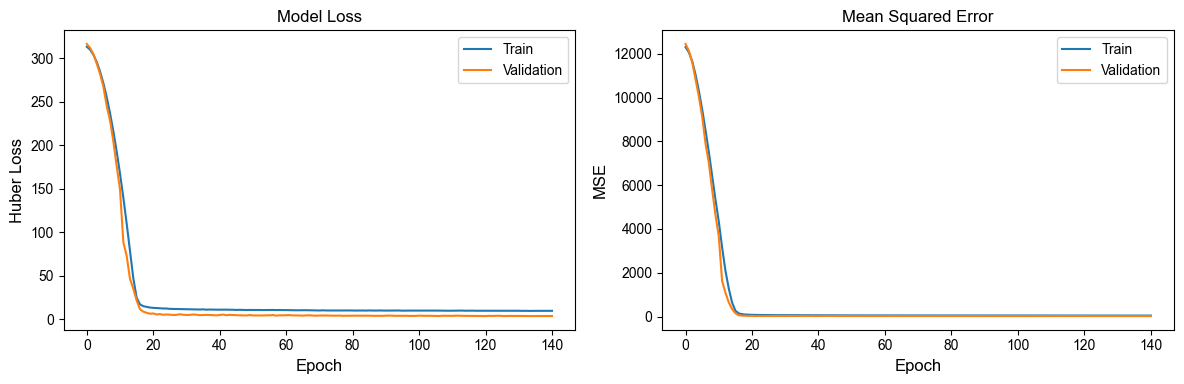

>>>> Model saved to ../artifacts/models/final_FFNN_model_sphere5.h5
-----------Testing the model performance on the test dataset-----------


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_1292/1884458441.py:23: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  content = content.apply(pd.to_numeric, errors="ignore")


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


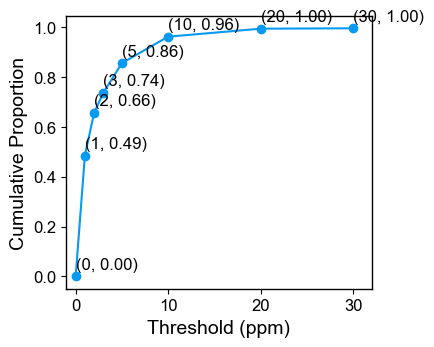

R2 = 0.98
RMSE = 4.36
MAE = 2.3994416384681627


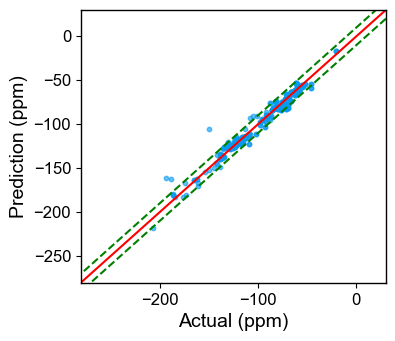

-----------Testing the model performance on the train dataset-----------


/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_1292/1884458441.py:23: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  content = content.apply(pd.to_numeric, errors="ignore")


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 638us/step


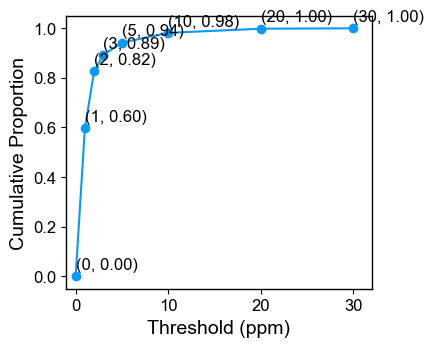

R2 = 0.99
RMSE = 3.17
MAE = 1.528280449641256


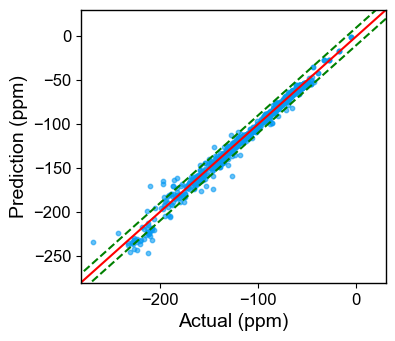

Test MAE: 2.40 ppm
Test RMSE: 4.36 ppm
Test R^2: 0.98
Train MAE: 1.53 ppm
Train RMSE: 3.17 ppm
Train R^2: 0.99


In [520]:
def test_2D_FFNN_model_on_validation_dataset(
    dataset, num_spheres, FFNN_2D_model_path, scaler_path, imputer_path, columns_path, verbose = True
):
    
    best_model = load_model(FFNN_2D_model_path)

    with open(scaler_path, "rb") as file:
        scaler = pickle.load(file)

    with open(imputer_path, "rb") as file:
        imputer = pickle.load(file)

    with open(columns_path, "rb") as file:
        train_columns = pickle.load(file)

    # with open(y_scaler_path, "rb") as file:
    #     y_scaler = pickle.load(file)

    get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
    content = get_2d_descriptors.getDescriptorsFromDataset(dataset, num_spheres)

    # Convert all columns in df to numeric where possible, keeping non-numeric values unchanged
    content = content.apply(pd.to_numeric, errors="ignore")

    # Conver column names to 'string'
    content.columns = content.columns.astype(str)

    # Delete columns not shown in the train dataset
    content = content[train_columns]

    # Drop rows with NaN values in the 'NMR_Peaks' column
    content = content.dropna(subset=["NMR_Peaks"])
    
    content_imputed = imputer.transform(content)

    content_imputed = pd.DataFrame(
        content_imputed, columns=content.columns, index=content.index
    )

    y = content_imputed["NMR_Peaks"]
    X = content_imputed.drop(["NMR_Peaks"], axis=1)

    X_scaled = scaler.transform(X)
    X_scaled = pd.DataFrame(X_scaled)
    X_scaled.columns = X.columns
    X_scaled.index = X.index

    # y = y_scaler.transform(y.values.reshape(-1, 1))
    # y_train_scaled = pd.DataFrame(y, index=X_scaled.index, columns=['NMR_Peaks'])

    results_table = common.get_results_table(best_model=best_model, X=X_scaled, y=y)

    # results_table['actual'] = y_scaler.inverse_transform(results_table['actual'].values.reshape(-1, 1)).flatten()
    # results_table['prediction'] = y_scaler.inverse_transform(results_table['prediction'].values.reshape(-1, 1)).flatten()
    # results_table['diff'] = np.abs(results_table['prediction'] - results_table['actual'])

    if verbose:
        common.plot_prediction_performance(results_table, figure_title=None)
        common.show_results_scatter(results_table, figure_title=None)
    return results_table

def test_2D_FFNN_model_performance(num_spheres, test_fluorinated_compounds):
    base_file_path = os.path.join("..", "artifacts", "models")
    restuls_table = test_2D_FFNN_model_on_validation_dataset(
        dataset=test_fluorinated_compounds,
        num_spheres=num_spheres,
        FFNN_2D_model_path=os.path.join(base_file_path, f"final_FFNN_model_sphere{num_spheres}.h5"),
        scaler_path=os.path.join(base_file_path, f"final_scaler_2d_sphere{num_spheres}_Ridge.pkl"),
        imputer_path=os.path.join(base_file_path, f"final_imputer_2d_sphere{num_spheres}_Ridge.pkl"),
        columns_path=os.path.join(base_file_path, f"final_column_names_2d_sphere{num_spheres}_Ridge.pkl"),
        # y_scaler_path=os.path.join(base_file_path, f"final_scaler_2d_sphere{num_spheres}_y.pkl"),
        verbose = True,
    )
    return restuls_table


FFNN_2d_model = Define_and_Train_FFNN_Model_2D(num_spheres=5, dataset=train_dataset)
print('-----------Testing the model performance on the test dataset-----------')
FFNN_2D_test_results_table = test_2D_FFNN_model_performance(
    num_spheres=5, 
    test_fluorinated_compounds=test_fluorinated_compounds
)
print('-----------Testing the model performance on the train dataset-----------')
train_results_table = test_2D_FFNN_model_performance(
    num_spheres=5, 
    test_fluorinated_compounds=train_dataset
)

test_mae = mean_absolute_error(FFNN_2D_test_results_table['actual'], FFNN_2D_test_results_table['prediction'])
test_mse = mean_squared_error(FFNN_2D_test_results_table['actual'], FFNN_2D_test_results_table['prediction'])
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(FFNN_2D_test_results_table['actual'], FFNN_2D_test_results_table['prediction'])
print(f"Test MAE: {test_mae:.2f} ppm")
print(f"Test RMSE: {test_rmse:.2f} ppm")
print(f"Test R^2: {test_r2:.2f}")

train_mae = mean_absolute_error(train_results_table['actual'], train_results_table['prediction'])
train_mse = mean_squared_error(train_results_table['actual'], train_results_table['prediction'])
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(train_results_table['actual'], train_results_table['prediction'])
print(f"Train MAE: {train_mae:.2f} ppm")
print(f"Train RMSE: {train_rmse:.2f} ppm")
print(f"Train R^2: {train_r2:.2f}")

In [428]:
# FFNN_2d_model = Define_and_Train_FFNN_Model_2D(num_spheres=5, dataset = train_dataset)

# print('-----------Testing the model performance on the test dataset-----------')
# FFNN_2D_test_results_table = test_FINAL_2D_FFNN_model_performance(dataset = test_fluorinated_compounds)

# print('-----------Testing the model performance on the train dataset-----------')
# train_results_table = test_FINAL_2D_FFNN_model_performance(dataset = train_dataset)

# test_mae = mean_absolute_error(FFNN_2D_test_results_table['actual'], FFNN_2D_test_results_table['prediction'])
# test_mse = mean_squared_error(FFNN_2D_test_results_table['actual'], FFNN_2D_test_results_table['prediction'])
# test_rmse = np.sqrt(test_mse)
# test_r2 = r2_score(FFNN_2D_test_results_table['actual'], FFNN_2D_test_results_table['prediction'])
# print(f"Test MAE: {test_mae:.2f} ppm")
# print(f"Test RMSE: {test_rmse:.2f} ppm")
# print(f"Test R^2: {test_r2:.2f}")

# train_mae = mean_absolute_error(train_results_table['actual'], train_results_table['prediction'])
# train_mse = mean_squared_error(train_results_table['actual'], train_results_table['prediction'])
# train_rmse = np.sqrt(train_mse)
# train_r2 = r2_score(train_results_table['actual'], train_results_table['prediction'])
# print(f"Train MAE: {train_mae:.2f} ppm")
# print(f"Train RMSE: {train_rmse:.2f} ppm")
# print(f"Train R^2: {train_r2:.2f}")

In [445]:
FFNN_2D_test_results_table

,actual,prediction,diff
4_ether_18,-79.60,-78.891251,0.708749
5_ether_18,-79.60,-78.891251,0.708749
8_ether_18,-90.60,-91.465218,0.865218
9_ether_18,-90.60,-91.465218,0.865218
11_ether_18,-90.60,-91.120392,0.520392
...,...,...,...
5_From_Review_360,-60.00,-56.204929,3.795071
6_From_Review_360,-60.00,-56.204929,3.795071
6_aromatics_5,-61.33,-62.702072,1.372072
7_aromatics_5,-61.33,-62.702076,1.372076


(0.0, 0.000)
(1.0, 0.486)
(2.0, 0.658)
(3.0, 0.738)
(5.0, 0.857)
(10.0, 0.963)
(20.0, 0.995)


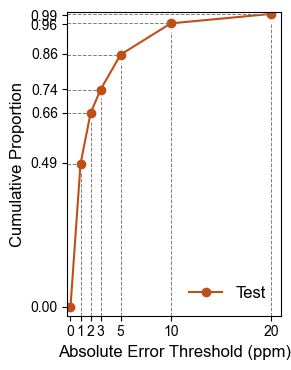

In [522]:
total_count = len(FFNN_2D_test_results_table)

cm = 1 / 2.54  # centimeters in inches
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(7 * cm, 10 * cm))

num_below_1, num_below_2, num_below_3, num_below_5, num_below_10, num_below_20 = (
    0,
    0,
    0,
    0,
    0,
    0,
)
for i in FFNN_2D_test_results_table["diff"]:
    if i < 20:
        num_below_20 += 1
    if i < 10:
        num_below_10 += 1
    if i < 5:
        num_below_5 += 1
    if i < 3:
        num_below_3 += 1
    if i < 2:
        num_below_2 += 1
    if i < 1:
        num_below_1 += 1

x = [0.0, 1.0, 2.0, 3.0, 5.0, 10.0, 20.0]
y = [0, num_below_1, num_below_2, num_below_3, num_below_5, num_below_10, num_below_20]
y = [val / total_count for val in y]

ax.plot(x, y, marker="o", markersize=6, color="#C04F16", alpha=1.0, label = 'Test')

for i in range(len(x)):
    # plt.annotate(f'({x[i]}, {y[i]:.0f}%)', (x[i], y[i]), textcoords="offset points", xytext=(0, 5), ha='left')
    print(f"({x[i]}, {y[i]:.3f})")
    # Draw vertical and horizontal lines
    ax.axvline(
        x=x[i], ymin=0, ymax=y[i]/1.03, color="grey", linestyle="--", linewidth=0.7
    )
    ax.axhline(
        y=y[i], xmin=0, xmax=x[i]/21.3, color="grey", linestyle="--", linewidth=0.7
    )

# Set the x and y ticks to match the data points
ax.set_xticks(x)
ax.set_yticks([.00, .49, .66, .74, .86, .96, .99])
ax.tick_params(axis="x", labelsize=tick_label_size)  # X-axis numbers font size
ax.tick_params(axis="y", labelsize=tick_label_size)  # Y-axis numbers font size

ax.set_xlabel("Absolute Error Threshold (ppm)", fontsize = axis_label_size)
ax.set_ylabel("Cumulative Proportion", fontsize = axis_label_size)
ax.set_xlim([-0.3, 21])
ax.set_ylim([-0.03, 1.0])
ax.legend(fontsize = 12, frameon=False)
plt.show()


-----------FFNN 2D model performance on test datasest-----------
R2 = 0.9776817430106991
RMSE = 4.36
Mean Absolute Error: 2.3994416384681627
-----------FFNN 2D model performance on train datasest-----------
Train R2 = 0.9906888003137733
Train RMSE = 3.17
Train Mean Absolute Error: 1.528280449641256


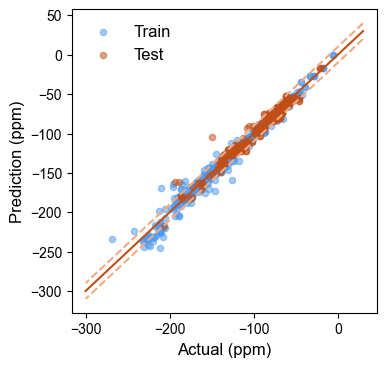

In [523]:
cm = 1 / 2.54  # centimeters in inches
plt.rcParams['font.family'] = 'Arial'
fig, ax = plt.subplots(figsize=(10 * cm, 10 * cm))
# "#4A90E2", "#50E3C2", "#F5A623", '#c95d63'

ax.plot([30, -300], [30, -300], c="#C04F16")
ax.plot([30, -300], [40, -290], c="#F2AA84", linestyle="dashed")
ax.plot([30, -300], [20, -310], c="#F2AA84", linestyle="dashed")
ax.scatter(
    x=train_results_table["actual"], y=train_results_table["prediction"], alpha=0.5, color="#4D9AF3", s = 20, label = 'Train'
    )

ax.scatter(
    x=FFNN_2D_test_results_table["actual"], y=FFNN_2D_test_results_table["prediction"], alpha=0.5, color="#C04F16", s = 20, label = 'Test'
    )

# "#C04F16", "#F2AA84", "#FBE3D6",

ax.tick_params(axis="x", labelsize=tick_label_size)  # X-axis numbers font size
ax.tick_params(axis="y", labelsize=tick_label_size)  # Y-axis numbers font size
ax.set_xlabel("Actual (ppm)", fontsize = axis_label_size)
ax.set_ylabel("Prediction (ppm)", fontsize = axis_label_size)
legend = ax.legend(
    loc="upper left", fontsize=12, frameon=False
)

r2 = r2_score(FFNN_2D_test_results_table["actual"], FFNN_2D_test_results_table["prediction"])
mse = mean_squared_error(FFNN_2D_test_results_table["actual"], FFNN_2D_test_results_table["prediction"])
rmse = math.sqrt(mse)
mae = mean_absolute_error(FFNN_2D_test_results_table["actual"], FFNN_2D_test_results_table["prediction"])
print('-----------FFNN 2D model performance on test datasest-----------')
print(f"R2 = {r2}")
print(f"RMSE = {rmse:.2f}")
print("Mean Absolute Error:", mae)
print('-----------FFNN 2D model performance on train datasest-----------')
train_r2 = r2_score(train_results_table["actual"], train_results_table["prediction"])
train_mse = mean_squared_error(train_results_table["actual"], train_results_table["prediction"])
train_rmse = math.sqrt(train_mse)
train_mae = mean_absolute_error(train_results_table["actual"], train_results_table["prediction"])
print(f"Train R2 = {train_r2}")
print(f"Train RMSE = {train_rmse:.2f}")
print("Train Mean Absolute Error:", train_mae)


In [480]:
def test_HOSE_model_performance(train_dataset, test_dataset):
    '''
    Splite the dataset into training and validation sets;
    Use the training set to build HOSE code database, which will be used to predict the NMR chemical shifts of fluorinated compounds in the validation set.
    Get the performance of the mode on the validatiaon dataset.
    '''

    HOSE_Code_database = hose_code.getHoseCodeContent(train_dataset)


    # Get HOSE Code and corresponding 19F NMR values using train dataset
    sphere_dics = hose_code.getTrainDictionary_HOSE(HOSE_Code_database)
    HOSE_Code_database["NMR_Peaks"] = HOSE_Code_database["NMR_Peaks"].astype(float)

    HOSE_codes_test = hose_code.getHoseCodeContent(test_dataset)

    # Get prediction results and corresponding similarity levels for the test dataset
    prediction, similarity_levels = hose_code.HOSE_Model(
        sphere_dics, test_data = HOSE_codes_test, mean_value_in_train_data = HOSE_Code_database["NMR_Peaks"].mean()
    )
    # Test dataset
    test_results_table = hose_code.getResults_HOSE(prediction, similarity_levels, HOSE_codes_test)

    test_results_table = test_results_table.dropna(subset = ['actual'])

    test_mae = mean_absolute_error(test_results_table['actual'], test_results_table['prediction'])
    test_mse = mean_squared_error(test_results_table['actual'], test_results_table['prediction'])
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(test_results_table['actual'], test_results_table['prediction'])

    print('--------Test results--------')
    print(f"Test MAE: {test_mae:.2f} ppm")
    print(f"Test RMSE: {test_rmse:.2f} ppm")
    print(f"Test R^2: {test_r2:.2f}")
    return HOSE_Code_database, HOSE_codes_test, test_results_table

HOSE_Code_database, HOSE_codes_test, hose_test_results_table = test_HOSE_model_performance(train_dataset, test_fluorinated_compounds)

[13:32:57] UFFTYPER: Warning: hybridization set to SP3 for atom 6


--------Test results--------
Test MAE: 3.47 ppm
Test RMSE: 8.85 ppm
Test R^2: 0.91


In [481]:
FFNN_2D_test_results_table['HOSE_model'] = hose_test_results_table['prediction']
FFNN_2D_test_results_table['similarity_levels'] = hose_test_results_table['similarity_levels']
FFNN_2D_test_results_table.head(5)

,actual,prediction,diff,HOSE_model,similarity_levels,ensemble_prediction
0,-79.6,-80.013924,0.413924,NaN,NaN,NaN
1,-79.6,-80.013924,0.413924,NaN,NaN,NaN
2,-90.6,-92.962692,2.362692,NaN,NaN,NaN
3,-90.6,-92.962692,2.362692,NaN,NaN,NaN
4,-90.6,-91.496201,0.896201,NaN,NaN,NaN


In [479]:
FFNN_2D_test_results_table['ensemble_prediction'] = np.where(
    FFNN_2D_test_results_table['similarity_levels'] < 4,
    FFNN_2D_test_results_table['prediction'],
    FFNN_2D_test_results_table['HOSE_model']
)
FFNN_2D_test_results_table.head()

,actual,prediction,diff,HOSE_model,similarity_levels,ensemble_prediction
0,-79.6,-80.013924,0.413924,NaN,NaN,NaN
1,-79.6,-80.013924,0.413924,NaN,NaN,NaN
2,-90.6,-92.962692,2.362692,NaN,NaN,NaN
3,-90.6,-92.962692,2.362692,NaN,NaN,NaN
4,-90.6,-91.496201,0.896201,NaN,NaN,NaN


In [456]:
ensemble_mae = mean_absolute_error(FFNN_2D_test_results_table['actual'], FFNN_2D_test_results_table['ensemble_prediction'])
ensemble_mse = mean_squared_error(FFNN_2D_test_results_table['actual'], FFNN_2D_test_results_table['ensemble_prediction'])
ensemble_rmse = np.sqrt(ensemble_mse)
ensemble_r2 = r2_score(FFNN_2D_test_results_table['actual'], FFNN_2D_test_results_table['ensemble_prediction'])
print('--------Ensemble results--------')
print(f"Ensemble MAE: {ensemble_mae:.2f} ppm")
print(f"Ensemble RMSE: {ensemble_rmse:.2f} ppm")
print(f"Ensemble R^2: {ensemble_r2:.2f}")

--------Ensemble results--------
Ensemble MAE: 2.12 ppm
Ensemble RMSE: 4.19 ppm
Ensemble R^2: 0.98


In [457]:
FFNN_2D_test_results_table['diff_ensemble'] = np.abs(FFNN_2D_test_results_table['ensemble_prediction'] - FFNN_2D_test_results_table['actual'])
FFNN_2D_test_results_table['diff_HOSE'] = np.abs(FFNN_2D_test_results_table['HOSE_model'] - FFNN_2D_test_results_table['actual'])

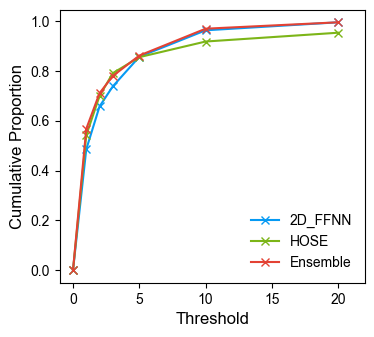

In [458]:
def plot_multi_prediction_performances(results_table, models = ["diff", "diff_HOSE", "diff_ensemble"],
                                        colors = ["#069AF3", "#7CB518", "#E34234"],
                                        labels = ["2D_FFNN", "HOSE", "Ensemble"]):
    total_count = len(results_table)
    cm = 1 / 2.54  # centimeters in inches
    fig, ax = plt.subplots(figsize=(10 * cm, 9 * cm))  # 8 cm x 8 cm

    for idx, diff in enumerate(models):
        (
            num_below_1,
            num_below_2,
            num_below_3,
            num_below_5,
            num_below_10,
            num_below_20,
        ) = (0, 0, 0, 0, 0, 0)
        for i in results_table[diff]:
            if i < 20:
                num_below_20 += 1
            if i < 10:
                num_below_10 += 1
            if i < 5:
                num_below_5 += 1
            if i < 3:
                num_below_3 += 1
            if i < 2:
                num_below_2 += 1
            if i < 1:
                num_below_1 += 1

        x = [0, 1, 2, 3, 5, 10, 20]
        y = [
            0,
            num_below_1,
            num_below_2,
            num_below_3,
            num_below_5,
            num_below_10,
            num_below_20,
        ]
        y = [val / total_count for val in y]

        if idx <= 4:
            ax.plot(x, y, marker="x", label=labels[idx], color=colors[idx])
            ax.set_xlabel("Threshold")
            ax.set_ylabel("Cumulative Proportion")
            # for i in range(len(x)):
            #     plt.annotate(f'({x[i]}, {y[i]:.2f})', (x[i], y[i]), textcoords="offset points", xytext=(0,5), ha='left')
        else:
            ax.plot(
                x,
                y,
                marker="o",
                label=labels[idx],
                color=colors[idx],
            )
            ax.set_xlabel("Threshold")
            ax.set_ylabel("Cumulative Proportion")

    ax.grid(False)
    ax.set_xlim([-1, 22])
    ax.legend(frameon=False)

    plt.show()

plot_multi_prediction_performances(FFNN_2D_test_results_table)

## 1.6.2 Approach 2. Add similarity level and HOSE model preditions as features to the FFNN model

In [ ]:
HOSE_file_path = os.path.join(
    "..", "artifacts", "results", "HOSE Results On Validation Dataset with 5 Random Seeds.csv"
)
hose_vali = pd.read_csv(HOSE_file_path)

# Top three performing models:
xgboost_train_3d_n5= pd.read_csv(os.path.join("..", "artifacts", "results", "XGBoost 3D_n5_Results On Training Dataset with 5 Random Seeds.csv"))
xgboost_vali_3d_n5= pd.read_csv(os.path.join("..", "artifacts", "results", "XGBoost 3D_n5_Results On Validation Dataset with 5 Random Seeds.csv.csv"))

xgboost_train_2d_s5= pd.read_csv(os.path.join("..", "artifacts", "results", "XGBoost 2D_s5_Results On Training Dataset with 5 Random Seeds.csv"))
xgboost_vali_2d_s5= pd.read_csv(os.path.join("..", "artifacts", "results", "XGBoost 2D_s5_Results On Validation Dataset with 5 Random Seeds.csv.csv"))

FFNN_train_2d_s5 = pd.read_csv(os.path.join("..", "artifacts", "results", "FFNN 2D_s5_Results On Training Dataset with 5 Random Seeds.csv"))
FFNN_vali_2d_s5 = pd.read_csv(os.path.join("..", "artifacts", "results", "FFNN 2D_s5_Results On Validation Dataset with 5 Random Seeds.csv.csv"))

# HOSE Code
HOSE_code_train_tables = pd.read_csv(os.path.join("..", "artifacts", "results", "HOSE_code_train_tables_with_5_random_seeds.csv"), index_col=0)

HOSE_code_vali_tables = pd.read_csv(os.path.join("..", "artifacts", "results", "HOSE_code_vali_tables_with_5_random_seeds.csv"), index_col=0)
HOSE_code_vali_tables = HOSE_code_vali_tables.dropna(subset = 'NMR_Peaks')



In [221]:
combined_prediction_results = hose_vali.copy()
combined_prediction_results.drop(columns=['Unnamed: 0', 'diff'], inplace=True)
combined_prediction_results['XGBoost_2D_s5'] = xgboost_vali_2d_s5['prediction']
combined_prediction_results['XGBoost_3D_n5'] = xgboost_vali_3d_n5['prediction']
combined_prediction_results['FFNN_2D_s5'] = FFNN_vali_2d_s5['prediction']
combined_prediction_results.head()

,actual,prediction,similarity_levels,XGBoost_2D_s5,XGBoost_3D_n5,FFNN_2D_s5
0,-120.1,-119.621538,4,-119.57432,-119.72106,-120.303345
1,-120.1,-119.621538,4,-119.57432,-119.72106,-120.303345
2,-122.8,-122.301818,4,-122.40083,-122.65971,-122.839386
3,-122.8,-122.301818,4,-122.40083,-122.62093,-122.839386
4,-122.8,-122.325000,4,-122.50487,-122.64747,-123.067890


In [232]:
X = combined_prediction_results.drop(columns=['actual'])
y = combined_prediction_results['actual']

# Use XGBoost model to predict the NMR shifts
xgb_ensemble_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=RANDOM_STATE
)
xgb_ensemble_model.fit(X, y)
# Evaluate the model
xgb_ensemble_results = xgb_ensemble_model.score(X, y)
print(f"XGBoost Ensemble Model - R^2 Score: {xgb_ensemble_results:.2f}")

XGBoost Ensemble Model - R^2 Score: 0.99


R2 = 0.99


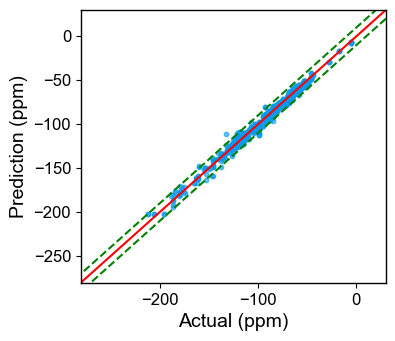

In [233]:
predictions = xgb_ensemble_model.predict(X)
fig, ax = plt.subplots(figsize=(10 * cm, 9 * cm))
ax.scatter(
        x=y,
        y=predictions,
        alpha=0.6,
        color="#069AF3",
        s=10
    )

ax.plot([30, -300], [30, -300], c="red")
ax.plot([30, -300], [40, -290], c="green", linestyle="dashed")
ax.plot([30, -300], [20, -310], c="green", linestyle="dashed")

r2 = r2_score(y, predictions)
ax.set_ylim([-280, 30])
ax.set_xlim([-280, 30])
print(f"R2 = {r2:.2f}")

# Set border (edge) line width
ax.spines["top"].set_linewidth(1)  # Top border
ax.spines["right"].set_linewidth(1)  # Right border
ax.spines["bottom"].set_linewidth(1)  # Bottom border
ax.spines["left"].set_linewidth(1)  # Left border

# Set axis titles and tick label font sizes
ax.set_xlabel("Actual (ppm)", fontsize=14)  # Replace with your label
ax.set_ylabel("Prediction (ppm)", fontsize=14)  # Replace with your label
ax.tick_params(axis="x", labelsize=12)  # X-axis numbers font size
ax.tick_params(axis="y", labelsize=12)  # Y-axis numbers font size
plt.show()

In [244]:
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
class Define_and_Train_XGboost_3D_Model():
    def __init__(self, num_neighbor, fluorinated_compounds, verbose = True):
        self.num_neighbor = num_neighbor
        fluorinated_compounds_w_Desc = self.step1_combine_atomic_feature_with_compounds(
            fluorinated_compounds, with_additional_info=True, verbose = verbose
        )
        self.processed_dataset = self.step2_data_preprocessing(fluorinated_compounds_w_Desc, verbose)
        self.bets_model, self.best_params = self.step3_model_training(
            self.processed_dataset,
            param_grid = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2},
            random_seed=RANDOM_STATE
        )
        return

    def step1_combine_atomic_feature_with_compounds(self, fluorinated_compounds, with_additional_info, verbose = True):
        # Combine NMR shift values of F atoms with its features
        fluorinated_compounds_w_Desc = atomic_features_3D.Combine_descriptors(
            fluorinated_compounds, num_neighbors=self.num_neighbor, with_additional_info=with_additional_info
        )
        fluorinated_compounds_w_Desc.rename_axis("atomCode_fluorinated_compoundsCode", inplace=True)
        fluorinated_compounds_w_Desc = fluorinated_compounds_w_Desc.apply(pd.to_numeric, errors="ignore") 
        
        if verbose:
            print(f"Shape of the fluorinated_compounds_w_Desc: {fluorinated_compounds_w_Desc.shape}")
            print(f'Save the train dataset to {file_path} successfully!')
        return fluorinated_compounds_w_Desc
    
    def step2_data_preprocessing(self, dataset, verbose = True):
        # Data preprocessing
        dataset = common.drop_constant_col(dataset)
        dataset_dropNaN = common.drop_high_ratio_NaN_cols(dataset)
        dataset_dropCat = common.drop_categorical_columns(dataset_dropNaN)

        # drop rows with NaN values in the 'NMR_Peaks' column
        dataset_dropNaN = dataset_dropCat.dropna(subset=["NMR_Peaks"])

        # Save column names
        columns = dataset_dropNaN.columns.tolist()
        file_path = os.path.join(
            f"..", "artifacts", "models", f"final_xgboost_3d_column_names_neighbor{self.num_neighbor}.pkl"
        )
        with open(file_path, "wb") as f:
            pickle.dump(columns, f)

        return dataset_dropNaN
    
    def step3_model_training(self, dataset, param_grid, random_seed):
        scoring = {
            "mae": "neg_mean_absolute_error",
            "rmse": make_scorer(
                mean_squared_error, squared=False, greater_is_better=False
            ),  # Root Mean Squared Error
            "r2": "r2",
        }

        y_train = dataset["NMR_Peaks"]
        X_train = dataset.drop(["NMR_Peaks"], axis=1)
        X_train = X_train.apply(pd.to_numeric)
        
        train_size = int(len(X_train) * 0.8)
        X_tr = X_train[:train_size]
        y_tr = y_train[:train_size]
        X_val = X_train[train_size:]
        y_val = y_train[train_size:]
   
        xgb_reg = XGBRegressor(early_stopping_rounds=20)
        if type(param_grid['n_estimators']) is list:
            # Initialize GridSearchCV
            random_search = RandomizedSearchCV(
                estimator=xgb_reg,
                param_distributions=param_grid,
                n_iter=30, # how many different combinations of hyperparameters will be randomly sampled and tested.
                cv=5,
                scoring=scoring,
                refit="mae",
                verbose=1,
                random_state=random_seed,
            )

            # Fit the model
            random_search.fit(X_tr, y_tr, eval_set = [(X_val, y_val)], verbose=False)

            # Get the best parameters
            best_params = random_search.best_params_
            best_model = random_search.best_estimator_

            print(f"Best parameters found: {best_params}")
        else:
            # If only one set of hyperparameters is provided, fit the model directly
            best_model = xgb_reg.set_params(**param_grid)
            best_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
            best_params = param_grid
            # Print out scoring metrics for the best model
    
        y_pred = best_model.predict(X_val)
        print(f'MAE Score: {mean_absolute_error(y_val, y_pred):.2f}')
        mse = mean_squared_error(y_val, y_pred)
        print(f'Root Mean Squared Error (RMSE): {np.sqrt(mse):.2f}')
        print(f'R^2 Score: {r2_score(y_val, y_pred):.2f}')

        # Save the model to a file
        file_path = os.path.join("..", "artifacts", "models", f"final_xgboost_model_neighbor{self.num_neighbor}.json")
        best_model.save_model(file_path)
        print(f'Save the model to {file_path} successfully!')
        return best_model, best_params


In [245]:
xgboost_3d_final_model = Define_and_Train_XGboost_3D_Model(num_neighbor=5, fluorinated_compounds=train_dataset, verbose=True)

/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_1292/1627702987.py:23: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  fluorinated_compounds_w_Desc = fluorinated_compounds_w_Desc.apply(pd.to_numeric, errors="ignore")


Shape of the fluorinated_compounds_w_Desc: (2973, 122)
Save the train dataset to ../artifacts/results/PFAS_HOSE_code_radii_1_error_thresholds.xlsx successfully!
MAE Score: 3.04
Root Mean Squared Error (RMSE): 5.93
R^2 Score: 0.97
Save the model to ../artifacts/models/final_xgboost_model_neighbor5.json successfully!


In [250]:
def testModelPerformance_XGBoost_3DNeighborAtoms(
    best_model_file_path = os.path.join("..", "artifacts", "models", f"final_xgboost_model_neighbor5.json"),
    columns_file_path = os.path.join(
            f"..", "artifacts", "models", f"final_xgboost_3d_column_names_neighbor5.pkl"
        ), 
    num_neighbor = 5, 
    test_dataset = test_fluorinated_compounds, 
    show_plot = True
):
    best_model = XGBRegressor()
    best_model.load_model(best_model_file_path)

    with open(columns_file_path, "rb") as f:
        train_cols = pickle.load(f)

    # Step 1. Combine NMR shift values of F atoms with its features
    fluorinated_compounds_w_Desc = atomic_features_3D.Combine_descriptors(
        test_dataset, num_neighbors=num_neighbor
    )

    # Step 3. Only keep columns that were used in the dataset for modeling while delete other columns
    fluorinated_compounds_w_Desc = fluorinated_compounds_w_Desc[train_cols]

    # For validation purpose, drop rows with NaN values in the 'NMR_Peaks' column
    fluorinated_compounds_w_Desc = fluorinated_compounds_w_Desc.dropna(
        subset=["NMR_Peaks"]
    )

    # Get y values
    y = fluorinated_compounds_w_Desc["NMR_Peaks"]
    X = fluorinated_compounds_w_Desc.drop(["NMR_Peaks"], axis=1)

    # Ensure all values in the X are numerical values
    X = X.apply(pd.to_numeric)

    results_table = common.get_results_table(best_model=best_model, X=X, y=y)

    if show_plot:
        common.plot_prediction_performance(results_table, figure_title=None)
        common.show_results_scatter(results_table, figure_title=None)

    return results_table


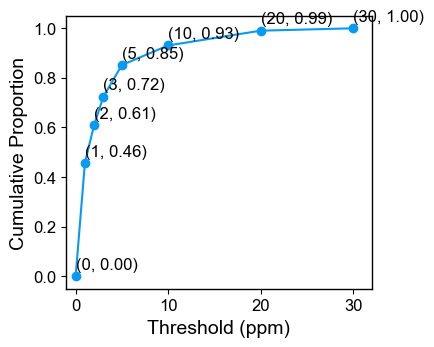

R2 = 0.97
RMSE = 5.26
MAE = 2.9064729187649547


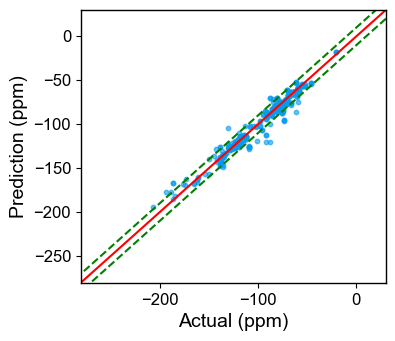

In [251]:
xgboost_3d_test_results = testModelPerformance_XGBoost_3DNeighborAtoms()

In [252]:
# XGBoost 2D
class Define_and_Train_Model_2D_XGBoost():
    def __init__(self, num_spheres = 5, fluorinated_compounds = train_dataset):
        self.num_spheres = num_spheres
        self.fluorinated_compounds = fluorinated_compounds
        self.processed_dataset = self.step1_get_features_and_data_preprocessing()
        self.best_model, self.best_params = self.step2_train_model(
            self.processed_dataset,
            param_grid = 
                {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2},
            random_seed=RANDOM_STATE
        )
        return
    
    def step1_get_features_and_data_preprocessing(self):
        get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
        dataset = get_2d_descriptors.getDescriptorsFromDataset(
            self.fluorinated_compounds, self.num_spheres
        )
        dataset = dataset.apply(pd.to_numeric, errors="ignore") 
        # Data processing is simple as XGBoost model can handle NaN values
        dataset = dataset.dropna(subset=["NMR_Peaks"])

        # Data preprocessing
        print(f'Shape of dataset before preprocessing: {dataset.shape}')
        dataset = common.drop_constant_col(dataset)
        dataset = common.drop_high_ratio_NaN_cols(dataset)
        dataset = common.drop_categorical_columns(dataset)
        print(f'Shape of dataset after preprocessing: {dataset.shape}')

        # Save column names
        dataset.columns = dataset.columns.astype(str)
        columns = dataset.columns.tolist()
        file_path = os.path.join(
            f"..", "artifacts", "models", f"Final_XGBoost_2D_column_names_sphere{self.num_spheres}.pkl"
        )
        with open(file_path, "wb") as f:
            pickle.dump(columns, f)
        return dataset

    def step2_train_model(self, dataset, param_grid, random_seed):
        y_train = dataset["NMR_Peaks"]
        X_train = dataset.drop(["NMR_Peaks"], axis=1)

        train_size = int(len(X_train) * 0.8)
        X_tr = X_train[:train_size]
        y_tr = y_train[:train_size]
        X_val = X_train[train_size:]
        y_val = y_train[train_size:]
   
        xgb_reg = XGBRegressor(early_stopping_rounds=20)
        scoring = {
            "mae": "neg_mean_absolute_error",
            "rmse": make_scorer(
                mean_squared_error, squared=False, greater_is_better=False
            ),
            "r2": "r2",
        }

        if type(param_grid['n_estimators']) is list:
            # Initialize GridSearchCV
            random_search = RandomizedSearchCV(
                estimator=xgb_reg,
                param_distributions=param_grid,
                n_iter=30, # how many different combinations of hyperparameters will be randomly sampled and tested.
                cv=5,
                scoring=scoring,
                refit="mae",
                verbose=1,
                random_state=random_seed,
            )

            # Fit the model
            random_search.fit(X_tr, y_tr, eval_set = [(X_val, y_val)],  # Use validation set for early stopping
                            verbose=False)
            # Get the best parameters
            best_params = random_search.best_params_
            print(f"Best parameters found: {best_params}")

            best_model = random_search.best_estimator_
        else:
            # If only one set of hyperparameters is provided, fit the model directly
            best_model = xgb_reg.set_params(**param_grid)
            best_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
            best_params = param_grid

        # Print out scoring metrics for the best model
        y_pred = best_model.predict(X_val)
        print(f'MAE Score: {mean_absolute_error(y_val, y_pred):.2f}')
        mse = mean_squared_error(y_val, y_pred)
        print(f'Root Mean Squared Error (RMSE): {np.sqrt(mse):.2f}')
        print(f'R^2 Score: {r2_score(y_val, y_pred):.2f}')

        # Save the model to a file
        file_path = os.path.join(
            "..", "artifacts", "models", f"final_xgboost_2d_descriptors_sphere{self.num_spheres}.json"
        )
        best_model.save_model(file_path)
        print(f'Save the model to {file_path} successfully!')
        return best_model, best_params


In [253]:
xgboost_2d_model = Define_and_Train_Model_2D_XGBoost()

/var/folders/37/_6vg83p95r9gj6cvkznnzz740000gn/T/ipykernel_1292/2381837078.py:20: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  dataset = dataset.apply(pd.to_numeric, errors="ignore")


Shape of dataset before preprocessing: (2878, 232)
Shape of dataset after preprocessing: (2878, 147)
MAE Score: 3.57
Root Mean Squared Error (RMSE): 6.65
R^2 Score: 0.96
Save the model to ../artifacts/models/final_xgboost_2d_descriptors_sphere5.json successfully!


In [255]:
def test_2D_XGBoost_models(num_spheres = 5, dataset = test_fluorinated_compounds, show_plot = False):
    file_path = os.path.join(
            "..", "artifacts", "models", f"final_xgboost_2d_descriptors_sphere5.json"
        )
    columns_path = os.path.join(
            f"..", "artifacts", "models", f"Final_XGBoost_2D_column_names_sphere5.pkl"
        )
    get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
    results_table = get_2d_descriptors.testXGBoost2DModelPerformance(
        XGBoost_model_path = file_path,
        columns_path = columns_path,
        dataset=dataset,
        num_spheres=num_spheres,
        show_plot = show_plot
    )
    return results_table

In [257]:
xgboost_2d_test_results = test_2D_XGBoost_models()

/Users/kiluarao/ML/SCI_Project/NMR 19F/19F_NMR_Spectrum Predictor/notebooks/../src/atomic_features_2D.py:538: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  content = content.apply(pd.to_numeric, errors="ignore")


In [261]:
hose_test_results_table

,actual,prediction,diff,similarity_levels
4_ether_18,-79.60,-79.650,0.050,6
5_ether_18,-79.60,-79.650,0.050,6
8_ether_18,-90.60,-90.300,0.300,6
9_ether_18,-90.60,-90.300,0.300,6
11_ether_18,-90.60,-90.300,0.300,6
...,...,...,...,...
5_From_Review_360,-60.00,-64.400,4.400,3
6_From_Review_360,-60.00,-64.400,4.400,3
6_aromatics_5,-61.33,-63.154,1.824,5
7_aromatics_5,-61.33,-63.154,1.824,5


R2 = 0.98


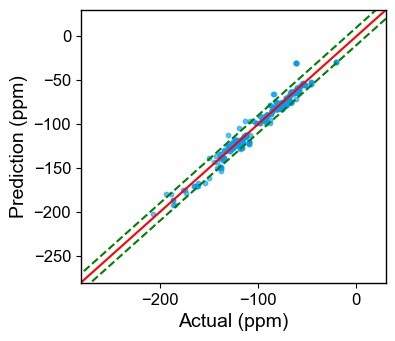

In [263]:
# Combine results from different models
combined_test_results = hose_test_results_table.copy()
combined_test_results.drop(columns=['diff'], inplace=True)
combined_test_results['XGBoost_2D_s5'] = xgboost_2d_test_results['prediction']
combined_test_results['XGBoost_3D_n5'] = xgboost_3d_test_results['prediction']
combined_test_results['FFNN_2D_s5'] = FFNN_2D_test_results_table['prediction']

X = combined_test_results.drop(columns=['actual'])
y = combined_test_results['actual']

# Use XGBoost model to predict the NMR shifts
test_predictions = xgb_ensemble_model.predict(X)

fig, ax = plt.subplots(figsize=(10 * cm, 9 * cm))
ax.scatter(
        x=y,
        y=test_predictions,
        alpha=0.6,
        color="#069AF3",
        s=10
    )

ax.plot([30, -300], [30, -300], c="red")
ax.plot([30, -300], [40, -290], c="green", linestyle="dashed")
ax.plot([30, -300], [20, -310], c="green", linestyle="dashed")

r2 = r2_score(y, test_predictions)
ax.set_ylim([-280, 30])
ax.set_xlim([-280, 30])
print(f"R2 = {r2:.2f}")

# Set border (edge) line width
ax.spines["top"].set_linewidth(1)  # Top border
ax.spines["right"].set_linewidth(1)  # Right border
ax.spines["bottom"].set_linewidth(1)  # Bottom border
ax.spines["left"].set_linewidth(1)  # Left border

# Set axis titles and tick label font sizes
ax.set_xlabel("Actual (ppm)", fontsize=14)  # Replace with your label
ax.set_ylabel("Prediction (ppm)", fontsize=14)  # Replace with your label
ax.tick_params(axis="x", labelsize=12)  # X-axis numbers font size
ax.tick_params(axis="y", labelsize=12)  # Y-axis numbers font size
plt.show()

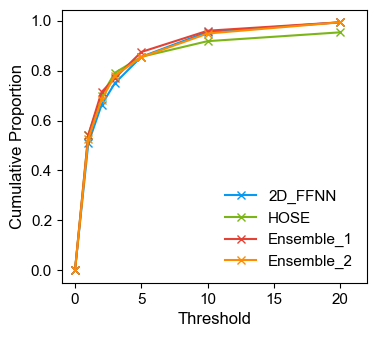

In [272]:
combined_test_results["ensembble_1"] = np.where(
    combined_test_results["similarity_levels"] < 4,
    combined_test_results["FFNN_2D_s5"],
    combined_test_results["prediction"],
)
combined_test_results['ensemble_2'] = test_predictions
combined_test_results['diff_FFNN'] = np.abs(combined_test_results['actual'] - combined_test_results['FFNN_2D_s5'])
combined_test_results['diff_HOSE'] = np.abs(combined_test_results['actual'] - combined_test_results['prediction'])
combined_test_results['diff_ensemble_1'] = np.abs(combined_test_results['actual'] - combined_test_results['ensembble_1'])
combined_test_results['diff_ensemble_2'] = np.abs(combined_test_results['actual'] - combined_test_results['ensemble_2'])

plot_multi_prediction_performances(combined_test_results, models = ["diff_FFNN", "diff_HOSE", "diff_ensemble_1", "diff_ensemble_2"],
                                        colors = ["#069AF3", "#7CB518", "#E34234", "#FF8C00"],
                                        labels = ["2D_FFNN", "HOSE", "Ensemble_1", "Ensemble_2"])

In [274]:
print('--------Ensemble 1 results--------')
ensemble_1_mae = mean_absolute_error(combined_test_results['actual'], combined_test_results['ensembble_1'])
ensemble_1_mse = mean_squared_error(combined_test_results['actual'], combined_test_results['ensembble_1'])
ensemble_1_rmse = np.sqrt(ensemble_1_mse)
ensemble_1_r2 = r2_score(combined_test_results['actual'], combined_test_results['ensembble_1'])
print(f"Ensemble 1 MAE: {ensemble_1_mae:.2f} ppm")
print(f"Ensemble 1 RMSE: {ensemble_1_rmse:.2f} ppm")
print(f"Ensemble 1 R^2: {ensemble_1_r2:.2f}")
print('--------Ensemble 2 results--------')
ensemble_2_mae = mean_absolute_error(combined_test_results['actual'], combined_test_results['ensemble_2'])
ensemble_2_mse = mean_squared_error(combined_test_results['actual'], combined_test_results['ensemble_2'])
ensemble_2_rmse = np.sqrt(ensemble_2_mse)
ensemble_2_r2 = r2_score(combined_test_results['actual'], combined_test_results['ensemble_2'])
print(f"Ensemble 2 MAE: {ensemble_2_mae:.2f} ppm")
print(f"Ensemble 2 RMSE: {ensemble_2_rmse:.2f} ppm")
print(f"Ensemble 2 R^2: {ensemble_2_r2:.2f}")
print('--------HOSE results--------')
hose_mae = mean_absolute_error(combined_test_results['actual'], combined_test_results['prediction'])
hose_mse = mean_squared_error(combined_test_results['actual'], combined_test_results['prediction'])
hose_rmse = np.sqrt(hose_mse)
hose_r2 = r2_score(combined_test_results['actual'], combined_test_results['prediction'])
print(f"HOSE MAE: {hose_mae:.2f} ppm")
print(f"HOSE RMSE: {hose_rmse:.2f} ppm")
print(f"HOSE R^2: {hose_r2:.2f}")
print('--------2D FFNN results--------')
ffnn_mae = mean_absolute_error(combined_test_results['actual'], combined_test_results['FFNN_2D_s5'])
ffnn_mse = mean_squared_error(combined_test_results['actual'], combined_test_results['FFNN_2D_s5'])
ffnn_rmse = np.sqrt(ffnn_mse)
ffnn_r2 = r2_score(combined_test_results['actual'], combined_test_results['FFNN_2D_s5'])
print(f"FFNN MAE: {ffnn_mae:.2f} ppm")
print(f"FFNN RMSE: {ffnn_rmse:.2f} ppm")
print(f"FFNN R^2: {ffnn_r2:.2f}")

--------Ensemble 1 results--------
Ensemble 1 MAE: 2.20 ppm
Ensemble 1 RMSE: 4.23 ppm
Ensemble 1 R^2: 0.98
--------Ensemble 2 results--------
Ensemble 2 MAE: 2.44 ppm
Ensemble 2 RMSE: 4.58 ppm
Ensemble 2 R^2: 0.98
--------HOSE results--------
HOSE MAE: 3.47 ppm
HOSE RMSE: 8.85 ppm
HOSE R^2: 0.91
--------2D FFNN results--------
FFNN MAE: 2.50 ppm
FFNN RMSE: 4.44 ppm
FFNN R^2: 0.98


In [275]:
FFNN_2D_test_results_table

,actual,prediction,diff,HOSE_model,similarity_levels,ensemble_prediction,diff_ensemble,diff_HOSE
4_ether_18,-79.60,-79.749664,0.149664,-79.650,6,-79.650000,0.050000,0.050
5_ether_18,-79.60,-79.749664,0.149664,-79.650,6,-79.650000,0.050000,0.050
8_ether_18,-90.60,-92.304916,1.704916,-90.300,6,-90.300000,0.300000,0.300
9_ether_18,-90.60,-92.304916,1.704916,-90.300,6,-90.300000,0.300000,0.300
11_ether_18,-90.60,-90.253181,0.346819,-90.300,6,-90.300000,0.300000,0.300
...,...,...,...,...,...,...,...,...
5_From_Review_360,-60.00,-57.792599,2.207401,-64.400,3,-57.792599,2.207401,4.400
6_From_Review_360,-60.00,-57.792599,2.207401,-64.400,3,-57.792599,2.207401,4.400
6_aromatics_5,-61.33,-63.620071,2.290071,-63.154,5,-63.154000,1.824000,1.824
7_aromatics_5,-61.33,-63.620071,2.290071,-63.154,5,-63.154000,1.824000,1.824
